In [4]:
import pandas as pd
import datetime as dt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [5]:
df= pd.read_csv('datos_arreglados.csv',index_col=0,parse_dates=True)
df

<ipython-input-5-e404f7da5ad4>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df= pd.read_csv('datos_arreglados.csv',index_col=0,parse_dates=True)


date                 item       category       department  \
0        2013-07-08     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
1        2013-07-15     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
2        2013-07-22     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
3        2013-07-29     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
4        2013-08-05     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
...             ...                  ...            ...              ...   
1989012  2013-03-18  HOME_&_GARDEN_1_362  HOME_&_GARDEN  HOME_&_GARDEN_1   
1989013  2013-03-25  HOME_&_GARDEN_1_362  HOME_&_GARDEN  HOME_&_GARDEN_1   
1989014  2013-04-01  HOME_&_GARDEN_1_362  HOME_&_GARDEN  HOME_&_GARDEN_1   
1989015  2013-04-08  HOME_&_GARDEN_1_362  HOME_&_GARDEN  HOME_&_GARDEN_1   
1989016  2013-04-15  HOME_&_GARDEN_1_362  HOME_&_GARDEN               HO   

                   stores    region  week    year  is_holidays  units_sold  \
0        South_End(BOS_1)    Boston  28.0  2013.0          0.0         0.0   
1        South_End(BOS_1)    Boston  28.0  2013.0          1.0         0.0   
2        South_End(BOS_1)    Boston  29.0  2013.0          0.0         4.0   
3        South_End(BOS_1)    Boston  30.0  2013.0          0.0         6.0   
4        South_End(BOS_1)    Boston  31.0  2013.0          0.0         0.0   
...                   ...       ...   ...     ...          ...         ...   
1989012     Harlem(NYC_2)  New York  11.0  2013.0          0.0         0.0   
1989013     Harlem(NYC_2)  New York  12.0  2013.0          0.0         0.0   
1989014     Harlem(NYC_2)  New York  13.0  2013.0          1.0         1.0   
1989015     Harlem(NYC_2)  New York  14.0  2013.0          0.0         0.0   
1989016               NaN       NaN   NaN     NaN          NaN         NaN   

         sell_price  total_sales  
0           12.7414       0.0000  
1           12.7414       0.0000  
2           10.9858      43.9432  
3           10.9858      65.9148  
4           10.9858       0.0000  
...             ...          ...  
1989012      9.9625       0.0000  
1989013      9.9625       0.0000  
1989014      9.9625       9.9625  
1989015      9.9625       0.0000  
1989016         NaN          NaN  

[1989017 rows x 12 columns]

In [6]:
df.stores.unique()


array(['South_End(BOS_1)', 'Roxbury(BOS_2)', 'Back_Bay(BOS_3)',
       'Greenwich_Village(NYC_1)', 'Harlem(NYC_2)', 'Tribeca(NYC_3)',
       'Brooklyn(NYC_4)', 'Midtown_Village(PHI_1)', 'Yorktown(PHI_2)',
       'Queen_Village(PHI_3)', nan], dtype=object)

In [7]:
# Prophet funciona mejor con eventos, asi que extraeremos los eventos mas importantes de nuestro csv de eventos.

df_events= pd.read_csv('daily_calendar_with_events.csv')
df_events

date    weekday  weekday_int       d event
0     2011-01-29   Saturday            1     d_1   NaN
1     2011-01-30     Sunday            2     d_2   NaN
2     2011-01-31     Monday            3     d_3   NaN
3     2011-02-01    Tuesday            4     d_4   NaN
4     2011-02-02  Wednesday            5     d_5   NaN
...          ...        ...          ...     ...   ...
1908  2016-04-20  Wednesday            5  d_1909   NaN
1909  2016-04-21   Thursday            6  d_1910   NaN
1910  2016-04-22     Friday            7  d_1911   NaN
1911  2016-04-23   Saturday            1  d_1912   NaN
1912  2016-04-24     Sunday            2  d_1913   NaN

[1913 rows x 5 columns]

In [8]:
# extraemos el df con los eventos filtrados:

df_events.dropna(inplace=True)

# cambiamos las columans para el prophet

df_events.rename(columns={'date':'ds','event':'holiday'},inplace=True)

df_events['ds']=pd.to_datetime(df_events['ds'])

# eliminamos las columnas que no interesan
df_events.drop(columns=['weekday','weekday_int','d'],inplace=True)
df_events

ds         holiday
8    2011-02-06       SuperBowl
184  2011-08-01  Ramadan starts
299  2011-11-24    Thanksgiving
337  2012-01-01         NewYear
372  2012-02-05       SuperBowl
435  2012-04-08          Easter
538  2012-07-20  Ramadan starts
663  2012-11-22    Thanksgiving
703  2013-01-01         NewYear
736  2013-02-03       SuperBowl
792  2013-03-31          Easter
892  2013-07-09  Ramadan starts
1034 2013-11-28    Thanksgiving
1068 2014-01-01         NewYear
1100 2014-02-02       SuperBowl
1177 2014-04-20          Easter
1247 2014-06-29  Ramadan starts
1398 2014-11-27    Thanksgiving
1433 2015-01-01         NewYear
1464 2015-02-01       SuperBowl
1527 2015-04-05          Easter
1601 2015-06-18  Ramadan starts
1762 2015-11-26    Thanksgiving
1798 2016-01-01         NewYear
1835 2016-02-07       SuperBowl
1884 2016-03-27          Easter

In [9]:
# Aparte añadiremos otros eventos importantes y fechas que se han producido en las tres ciudades.

eventos = [
    {'fecha': '2011-11-25', 'evento': 'Black Friday'},
    {'fecha': '2012-11-23', 'evento': 'Black Friday'},
    {'fecha': '2013-11-29', 'evento': 'Black Friday'},
    {'fecha': '2014-11-28', 'evento': 'Black Friday'},
    {'fecha': '2015-11-27', 'evento': 'Black Friday'},
    {'fecha': '2016-11-25', 'evento': 'Black Friday'},
    {'fecha': '2017-11-24', 'evento': 'Black Friday'},
    {'fecha': '2011-10-31', 'evento': 'Halloween'},
    {'fecha': '2012-10-31', 'evento': 'Halloween'},
    {'fecha': '2013-10-31', 'evento': 'Halloween'},
    {'fecha': '2014-10-31', 'evento': 'Halloween'},
    {'fecha': '2015-10-31', 'evento': 'Halloween'},
    {'fecha': '2016-10-31', 'evento': 'Halloween'},
    {'fecha': '2017-10-31', 'evento': 'Halloween'},
    {'fecha': '2011-07-04', 'evento': 'Independence Day'},
    {'fecha': '2012-07-04', 'evento': 'Independence Day'},
    {'fecha': '2013-07-04', 'evento': 'Independence Day'},
    {'fecha': '2014-07-04', 'evento': 'Independence Day'},
    {'fecha': '2015-07-04', 'evento': 'Independence Day'},
    {'fecha': '2016-07-04', 'evento': 'Independence Day'},
    {'fecha': '2017-07-04', 'evento': 'Independence Day'},
    {'fecha': '2011-04-24', 'evento': 'Easter'},
    {'fecha': '2012-04-08', 'evento': 'Easter'},
    {'fecha': '2013-03-31', 'evento': 'Easter'},
    {'fecha': '2014-04-20', 'evento': 'Easter'},
    {'fecha': '2015-04-05', 'evento': 'Easter'},
    {'fecha': '2016-03-27', 'evento': 'Easter'},
    {'fecha': '2017-04-16', 'evento': 'Easter'},
    {'fecha': '2011-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2012-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2013-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2014-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2015-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2016-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2017-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2011-05-08', 'evento': "Mother's Day"},
    {'fecha': '2012-05-13', 'evento': "Mother's Day"},
    {'fecha': '2013-05-12', 'evento': "Mother's Day"},
    {'fecha': '2014-05-11', 'evento': "Mother's Day"},
    {'fecha': '2015-05-10', 'evento': "Mother's Day"},
    {'fecha': '2016-05-08', 'evento': "Mother's Day"},
    {'fecha': '2017-05-14', 'evento': "Mother's Day"},
    {'fecha': '2011-06-19', 'evento': "Father's Day"},
    {'fecha': '2012-06-17', 'evento': "Father's Day"},
    {'fecha': '2013-06-16', 'evento': "Father's Day"},
    {'fecha': '2014-06-15', 'evento': "Father's Day"},
    {'fecha': '2015-06-21', 'evento': "Father's Day"},
    {'fecha': '2016-06-19', 'evento': "Father's Day"},
    {'fecha': '2017-06-18', 'evento': "Father's Day"},
    {'fecha': '2011-12-25', 'evento': "Christmas"},
    {'fecha': '2012-12-25', 'evento': "Christmas"},
    {'fecha': '2013-12-25', 'evento': "Christmas"},
    {'fecha': '2014-12-25', 'evento': "Christmas"},
    {'fecha': '2015-12-25', 'evento': "Christmas"},
    {'fecha': '2016-12-25', 'evento': "Christmas"},
    {'fecha': '2017-12-25', 'evento': "Christmas"},
    {'fecha': '2011-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2012-11-04', 'evento': 'NYC Marathon'},
    {'fecha': '2013-11-03', 'evento': 'NYC Marathon'},
    {'fecha': '2014-11-02', 'evento': 'NYC Marathon'},
    {'fecha': '2015-11-01', 'evento': 'NYC Marathon'},
    {'fecha': '2016-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2017-11-05', 'evento': 'NYC Marathon'},
    {'fecha': '2011-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2012-04-16', 'evento': 'Boston Marathon'},
    {'fecha': '2013-04-15', 'evento': 'Boston Marathon'},
    {'fecha': '2014-04-21', 'evento': 'Boston Marathon'},
    {'fecha': '2015-04-20', 'evento': 'Boston Marathon'},
    {'fecha': '2016-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2017-04-17', 'evento': 'Boston Marathon'},
    {'fecha': '2011-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2012-06-24', 'evento': 'NYC Pride'},
    {'fecha': '2013-06-30', 'evento': 'NYC Pride'},
    {'fecha': '2014-06-29', 'evento': 'NYC Pride'},
    {'fecha': '2015-06-28', 'evento': 'NYC Pride'},
    {'fecha': '2016-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2017-06-25', 'evento': 'NYC Pride'},
    {'fecha': '2011-08-30', 'evento': "Eid al-Fitr"},
    {'fecha': '2012-08-19', 'evento': "Eid al-Fitr"},
    {'fecha': '2013-08-08', 'evento': "Eid al-Fitr"},
    {'fecha': '2014-07-28', 'evento': "Eid al-Fitr"},
    {'fecha': '2015-07-17', 'evento': "Eid al-Fitr"},
    {'fecha': '2016-07-06', 'evento': "Eid al-Fitr"},
    {'fecha': '2017-06-25', 'evento': "Eid al-Fitr"},
    {'fecha': '2011-12-20', 'evento': 'Hanukkah'},
    {'fecha': '2012-12-08', 'evento': 'Hanukkah'},
    {'fecha': '2013-11-27', 'evento': 'Hanukkah'},
    {'fecha': '2014-12-16', 'evento': 'Hanukkah'},
    {'fecha': '2015-12-06', 'evento': 'Hanukkah'},
    {'fecha': '2016-12-24', 'evento': 'Hanukkah'},
    {'fecha': '2017-12-12', 'evento': 'Hanukkah'},
    {'fecha': '2011-10-26', 'evento': 'Diwali'},
    {'fecha': '2012-11-13', 'evento': 'Diwali'},
    {'fecha': '2013-11-03', 'evento': 'Diwali'},
    {'fecha': '2014-10-23', 'evento': 'Diwali'},
    {'fecha': '2015-11-11', 'evento': 'Diwali'},
    {'fecha': '2016-10-30', 'evento': 'Diwali'},
    {'fecha': '2017-10-19', 'evento': 'Diwali'}
]


In [10]:
# y creamos df con los eventos nuevos.

df_new_events= pd.DataFrame(eventos)

# cambiamos columnas para que sean las mismas que para nuestra futura df para prophet.
df_new_events.rename(columns={'fecha':'ds','evento':'holiday'},inplace=True)
# y el formato datetime
df_new_events['ds']=pd.to_datetime(df_new_events['ds'])


df_new_events

ds       holiday
0  2011-11-25  Black Friday
1  2012-11-23  Black Friday
2  2013-11-29  Black Friday
3  2014-11-28  Black Friday
4  2015-11-27  Black Friday
..        ...           ...
93 2013-11-03        Diwali
94 2014-10-23        Diwali
95 2015-11-11        Diwali
96 2016-10-30        Diwali
97 2017-10-19        Diwali

[98 rows x 2 columns]

In [11]:
# concatenamos las dos dataframes

df_events = pd.concat([df_events, df_new_events], ignore_index=True)
df_events

ds         holiday
0   2011-02-06       SuperBowl
1   2011-08-01  Ramadan starts
2   2011-11-24    Thanksgiving
3   2012-01-01         NewYear
4   2012-02-05       SuperBowl
..         ...             ...
119 2013-11-03          Diwali
120 2014-10-23          Diwali
121 2015-11-11          Diwali
122 2016-10-30          Diwali
123 2017-10-19          Diwali

[124 rows x 2 columns]

In [12]:
# Creamos 10 df con los datos de las distintas tiendas para hacer las distintas predicciones adaptando los datos para prophet:

# recordemos que los nombres de las columnas han de ser especificos para prophet, 'ds' y 'y' y que 'ds' ha de ser datetime.


df.rename(columns={'date':'ds','total_sales':'y'},inplace=True)
df['ds']=pd.to_datetime(df['ds'])

# Creamos los df para cada tienda agrupando ventas por dia.

# BO

df_prophet_BOS_1_South_End= df[df['stores'] == 'South_End(BOS_1)'].groupby('ds')['y'].sum().reset_index()
df_prophet_BOS_2_Roxbury= df[df['stores'] == 'Roxbury(BOS_2)'].groupby('ds')['y'].sum().reset_index()
df_prophet_BOS_3_Back_Bay= df[df['stores'] == 'Back_Bay(BOS_3)'].groupby('ds')['y'].sum().reset_index()

# NY

df_prophet_NYC_1_Greenwich_Village= df[df['stores'] == 'Greenwich_Village(NYC_1)'].groupby('ds')['y'].sum().reset_index()
df_prophet_NYC_2_Harlem= df[df['stores'] == 'Harlem(NYC_2)'].groupby('ds')['y'].sum().reset_index()
df_prophet_NYC_3_Tribeca= df[df['stores'] == 'Tribeca(NYC_3)'].groupby('ds')['y'].sum().reset_index()
df_prophet_NYC_4_Brooklyn= df[df['stores'] == 'Brooklyn(NYC_4)'].groupby('ds')['y'].sum().reset_index()

# PHI

df_prophet_PHI_1_Midtown_Village= df[df['stores'] == 'Midtown_Village(PHI_1)'].groupby('ds')['y'].sum().reset_index()
df_prophet_PHI_2_Yorktown= df[df['stores'] == 'Yorktown(PHI_2)'].groupby('ds')['y'].sum().reset_index()
df_prophet_PHI_3_Queen_Village= df[df['stores'] == 'Queen_Village(PHI_3)'].groupby('ds')['y'].sum().reset_index()


# visualizamos un ejemplo
df_prophet_BOS_1_South_End


ds           y
0   2011-01-31   1212.3211
1   2011-02-07   9919.9558
2   2011-02-14  11483.1649
3   2011-02-21  12561.1472
4   2011-02-28  11115.7363
..         ...         ...
269 2016-03-28  26030.8279
270 2016-04-04  27937.1256
271 2016-04-11  27944.6273
272 2016-04-18  25402.5270
273 2016-04-25  23466.0935

[274 rows x 2 columns]

## South End Boston


In [13]:
# empezaremos con el de South_End.

df_prophet_BOS_1_South_End


ds           y
0   2011-01-31   1212.3211
1   2011-02-07   9919.9558
2   2011-02-14  11483.1649
3   2011-02-21  12561.1472
4   2011-02-28  11115.7363
..         ...         ...
269 2016-03-28  26030.8279
270 2016-04-04  27937.1256
271 2016-04-11  27944.6273
272 2016-04-18  25402.5270
273 2016-04-25  23466.0935

[274 rows x 2 columns]

ds           holiday
0   2011-02-06         SuperBowl
1   2011-08-01    Ramadan starts
2   2011-11-24      Thanksgiving
3   2012-01-01           NewYear
4   2012-02-05         SuperBowl
..         ...               ...
120 2014-10-23            Diwali
121 2015-11-11            Diwali
122 2016-10-30            Diwali
123 2017-10-19            Diwali
124 2016-01-07  Jonas Superstorm

[125 rows x 2 columns]

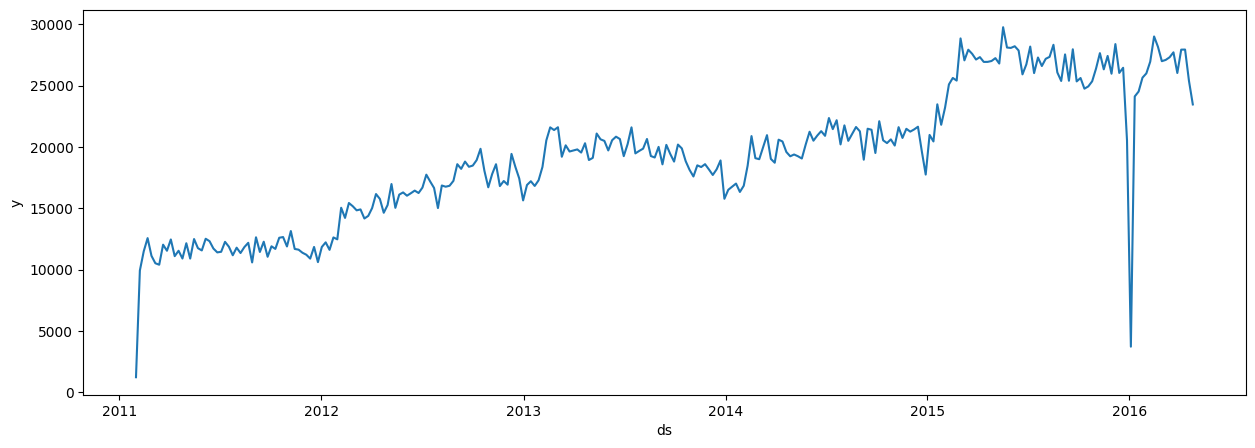

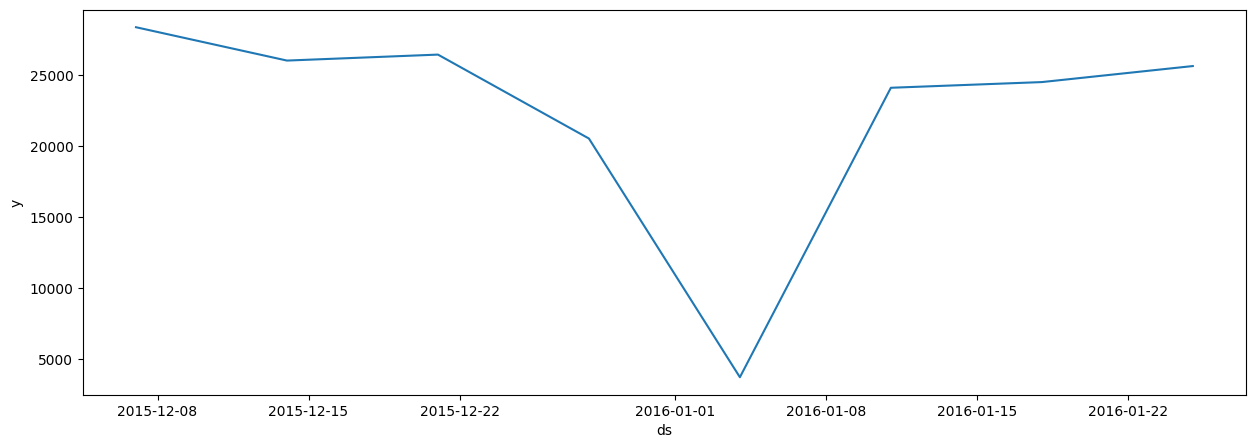

In [14]:
# vamos a representar graficamente las ventas a lo largo del tiempo
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 5))


sns.lineplot(data=df_prophet_BOS_1_South_End,x='ds',y='y')

# visualizamos en concreto los meses de diciembre 2015 y enero 2016

plt.figure(figsize=(15, 5))
sns.lineplot(data= df_prophet_BOS_1_South_End[(df_prophet_BOS_1_South_End['ds'] >= '2015-12-01') & (df_prophet_BOS_1_South_End['ds'] <= '2016-01-31')],x='ds',y='y')


# vemos que para el 10 de enero de 2016 existe un descenso en ventas considerable. No se si podria deberse a una tormenta invernal :
# Supertormenta Jonas (22 Enero 2016) importante notar que enero de 2016 fue el mes en el que ocurrió una gran tormenta de nieve en Estados Unidos, afectando principalmente a la región
#  del Atlántico Medio y el Noreste, incluyendo ciudades como Washington D.C., Filadelfia y Nueva York con 1-2.5 pies (12-30 pulgadas) de nieve​ (Wikipedia)​.


# he revisado en NY y pasa mas de lo mismo, asi que podria tener sentido. Añadimos el evento


# Crear un nuevo DataFrame con la fila que deseas agregar
new_row = pd.DataFrame({'ds': [pd.to_datetime('2016-01-07')], 'holiday': ['Jonas Superstorm']})

# Concatenar el nuevo DataFrame con df_events
df_events = pd.concat([df_events, new_row], ignore_index=True)

# Verificar el DataFrame resultante
display(df_events)


## Modelaje Prophet

In [15]:
# Creamos a su vez un df_global para ver las predicciones globales. incluiremos esto mas abajo en la funcion prophet.
df_global=pd.read_csv('datos_arreglados.csv',index_col=0)
df_global_prophet= df_global.groupby('date')['total_sales'].sum().reset_index()
df_global_prophet.rename(columns={'date':'ds','total_sales':'y'},inplace=True)
df_global_prophet['ds']=pd.to_datetime(df_global_prophet['ds'])
df_global_prophet

ds            y
0   2011-01-31   17082.7516
1   2011-02-07  131820.6274
2   2011-02-14  141716.3849
3   2011-02-21  152335.2128
4   2011-02-28  138795.9666
..         ...          ...
269 2016-03-28  314717.1533
270 2016-04-04  351347.9815
271 2016-04-11  342016.1949
272 2016-04-18  323829.8151
273 2016-04-25  293394.8166

[274 rows x 2 columns]

In [30]:
# creamos una funcion que nos permita hacer las predicciones con prophet por cada tienda independientemente y podamos volver a ejecutarla mas
# tarde de cara al deploy en MLOps (se pueda actualizar con nuevos datos)

'''
Esta funcion computa las predicciones de prophet y las ejecuta tienda por tienda iterando por cada una de ellas.
Ademas representaremos las 10 tiendas en un subplot para poder compararlas visualmente. cada una con sus predicciones vecinas
posteriormente podremos visualizar las metricas (MAPE y R2) para cada tienda
ademas podremos ajustar la prediccion al numero de semanas que queramos (periods_weeks).

Al final del todo se generara un df con las predicciones futuras de las tiendas y el global así como el historico.
dichos valores historicos en futuro se muestran como NaN (no existe en el historico el futuro)
.'''

# creamos un diccionario de tiendas para ir iterando por cada una de ellas (df_prophet)
dict_tienda= {'South_End_BOS_1': df_prophet_BOS_1_South_End,
                'Roxbury_BOS_2': df_prophet_BOS_2_Roxbury,
                'Back_Bay_BOS_3': df_prophet_BOS_3_Back_Bay,
                'Greenwich_Village_NYC_1': df_prophet_NYC_1_Greenwich_Village,
                'Harlem_NYC_2': df_prophet_NYC_2_Harlem,
                'Tribeca_NYC_3': df_prophet_NYC_3_Tribeca,
                'Brooklyn_NYC_4': df_prophet_NYC_4_Brooklyn,
                'Midtown_Village_PHI_1': df_prophet_PHI_1_Midtown_Village,
                'Yorktown_PHI_2': df_prophet_PHI_2_Yorktown,
                'Queen_Village_PHI_3': df_prophet_PHI_3_Queen_Village,
                'Global sales':df_global_prophet}


def prophet_store_prediction(dict_tienda, df_events, periods_weeks):
    # Configurar el tamaño de la figura para los subplots
    plt.figure(figsize=(20, 40))

    # Inicializamos una lista vacía para almacenar los resultados de todas las tiendas
    todas_predicciones = []

    for idx, (nombre_tienda, df_tienda) in enumerate(dict_tienda.items()):
        # hacemos hiperparameter tunning

        model= Prophet(holidays=df_events, seasonality_mode='multiplicative',
                       changepoint_prior_scale=0.10,changepoint_range=0.8, seasonality_prior_scale=10, holidays_prior_scale=10, interval_width=0.95)



        '''
         (freq=None, add_seasonality=None, add_country_holidays=None,
         growth='linear', growth_floor=0.0, growth_cap=None, changepoints=None,
         n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto',
         weekly_seasonality='auto', daily_seasonality='auto', holidays=None,
         seasonality_mode='additive', seasonality_prior_scale=10.0,
         holidays_prior_scale=10.0, changepoint_prior_scale=0.05,
         mcmc_samples=0, alpha=0.05, uncertainty_samples=1000,
         stan_backend=None, verbose=0, fit_kwargs=None)
'''

        model.fit(df_tienda)
        future = model.make_future_dataframe(periods=periods_weeks,freq='W') #* 7) # Asumiendo periods_weeks se da en semanas
        forecast = model.predict(future)

        # Seleccionamos el subplot adecuado
        ax = plt.subplot(6, 2, idx + 1)

        # Visualizamos los datos históricos y las predicciones
        sns.lineplot(data=df_tienda, x='ds', y='y', label='Datos históricos', ax=ax)
        sns.lineplot(data=forecast, x='ds', y='yhat', label='Predicción', ax=ax)

        # Añadimos los intervalos de confianza
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Intervalo de confianza')

        # Agregar las predicciones a la lista
        forecast['store'] = nombre_tienda
        forecast = forecast[['ds', 'store', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]
        forecast['y'] = df_tienda.set_index('ds').reindex(forecast.set_index('ds').index)['y'].reset_index(drop=True)
        todas_predicciones.append(forecast)


        # Limitamos el cálculo del MAPE y R2 solo a las fechas históricas
        forecasted = forecast[['ds', 'yhat']].merge(df_tienda, on='ds', how='right')
        y_true = df_tienda['y']
        y_pred = forecasted['yhat']


        # Calculamos el MAPE y R2
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Título del subplot
        plt.title(f'{nombre_tienda} - MAPE: {mape:.2f}%, R2: {r2:.2f}')
        # Rotar las etiquetas del eje X para mejor lectura

        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Concatenar todas las predicciones en un único DataFrame
    df_predicciones_prophet = pd.concat(todas_predicciones, ignore_index=True)

    return df_predicciones_prophet




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/g9m_wg10.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/0426ypvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98127', 'data', 'file=/tmp/tmpx__sqktv/g9m_wg10.json', 'init=/tmp/tmpx__sqktv/0426ypvh.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modeln5krt2k4/prophet_model-20240410145604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

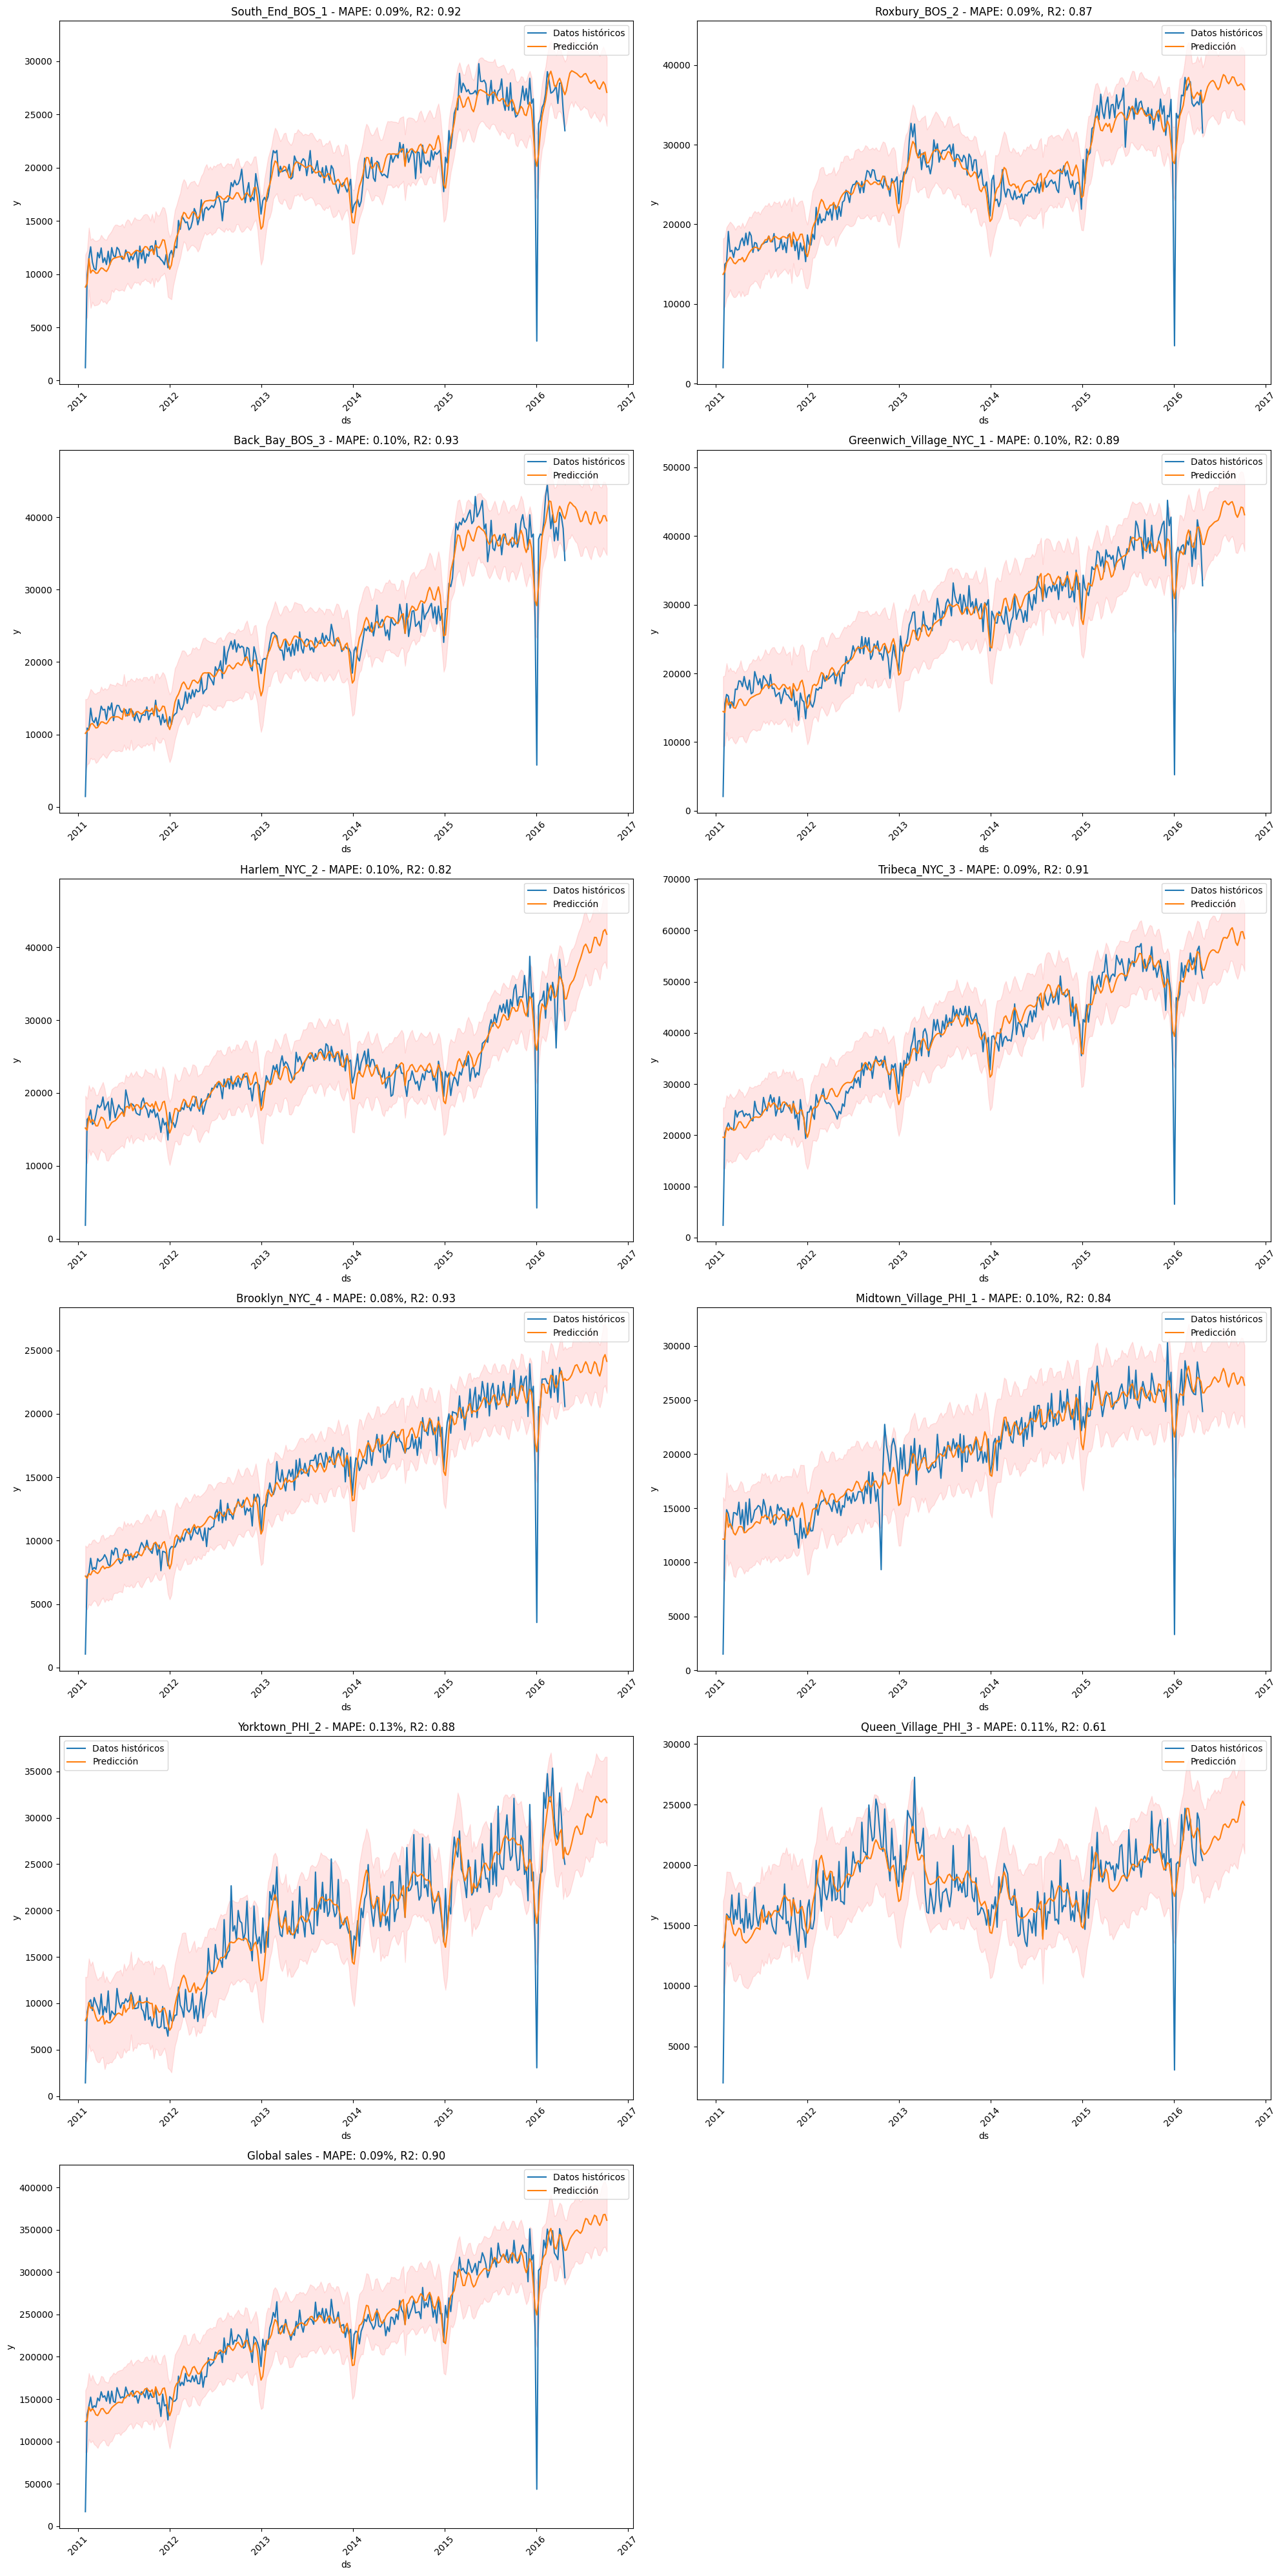

ds            store           yhat          trend     yhat_lower  \
0    2011-01-31  South_End_BOS_1    8787.119917    9137.095620    5751.974608   
1    2011-02-07  South_End_BOS_1    9107.370623    9232.890502    5927.448542   
2    2011-02-14  South_End_BOS_1   11447.033502    9328.685383    8539.571821   
3    2011-02-21  South_End_BOS_1   10107.995262    9424.480265    6811.328272   
4    2011-02-28  South_End_BOS_1   10370.672537    9520.275147    7389.259111   
...         ...              ...            ...            ...            ...   
3273 2016-09-11     Global sales  355166.552865  350837.682383  319569.154581   
3274 2016-09-18     Global sales  360182.393357  351680.219798  324317.314719   
3275 2016-09-25     Global sales  367684.012359  352522.757213  328870.692361   
3276 2016-10-02     Global sales  368203.117088  353365.294628  329866.686095   
3277 2016-10-09     Global sales  361311.188654  354207.832043  324179.003600   

         yhat_upper           y  
0      11821.494504   1212.3211  
1      12201.903065   9919.9558  
2      14362.908669  11483.1649  
3      13209.641044  12561.1472  
4      13365.083353  11115.7363  
...             ...         ...  
3273  389963.657547         NaN  
3274  400195.910242         NaN  
3275  405777.822830         NaN  
3276  407195.572494         NaN  
3277  399903.413404         NaN  

[3278 rows x 7 columns]

In [31]:

df_predicciones_prophet = prophet_store_prediction(dict_tienda, df_events, 24)
df_predicciones_prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/_pms1whd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/hl1akuuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62423', 'data', 'file=/tmp/tmpx__sqktv/_pms1whd.json', 'init=/tmp/tmpx__sqktv/hl1akuuv.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modeliuuw92td/prophet_model-20240410132530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

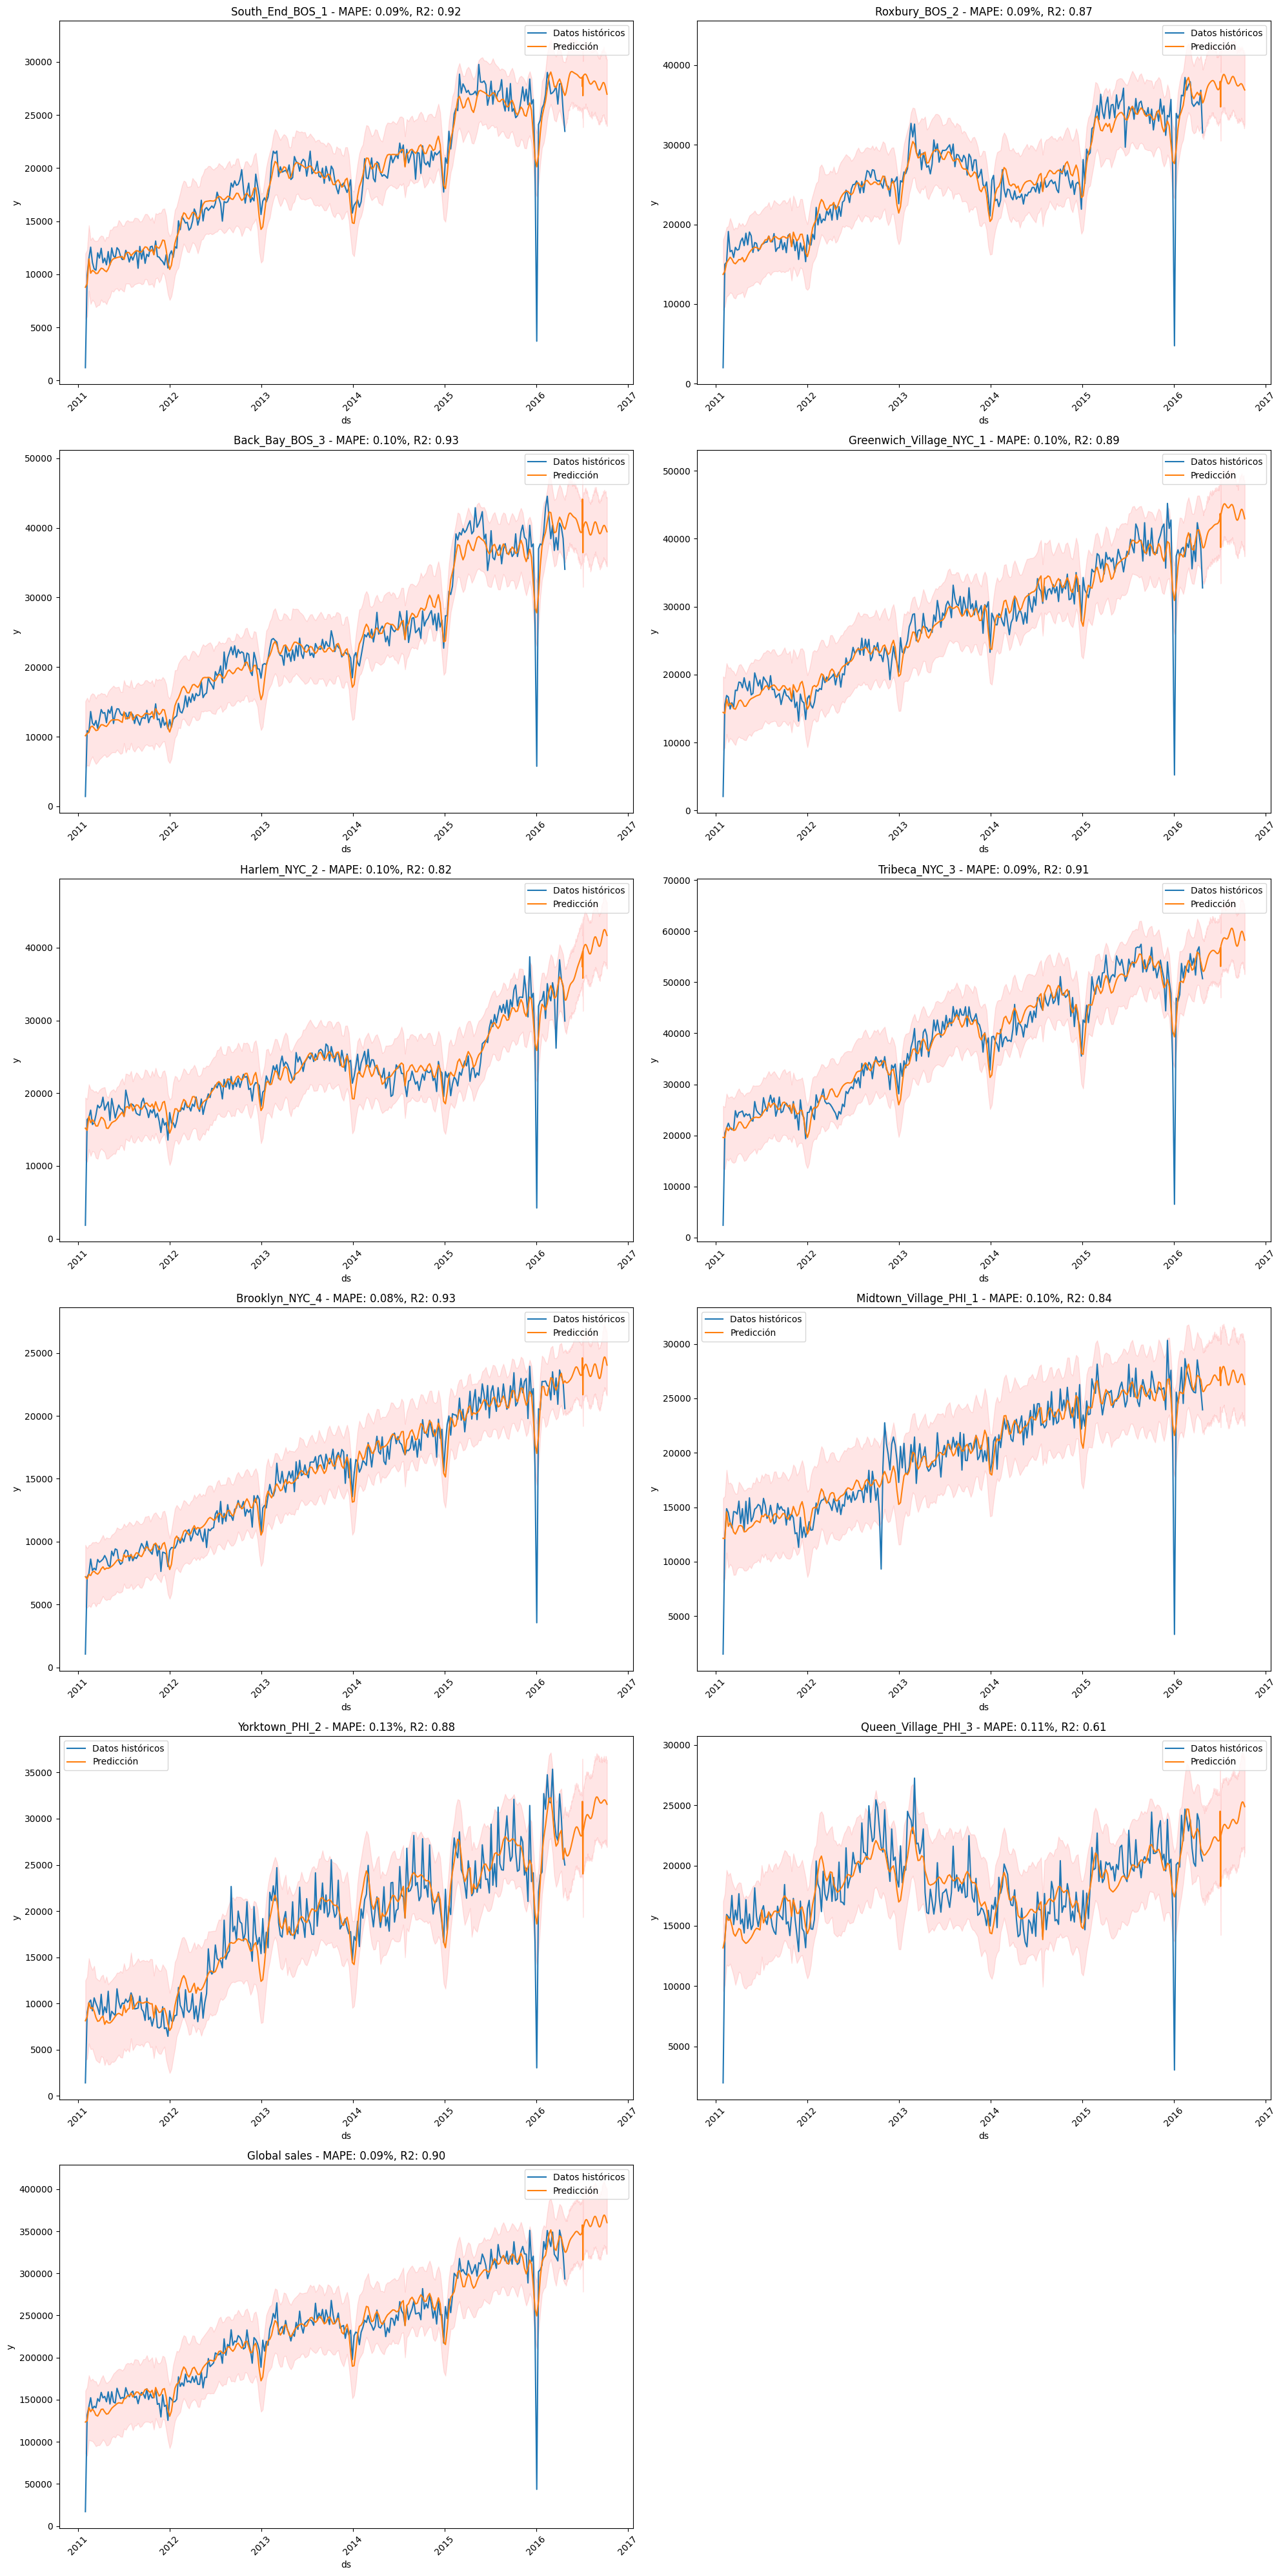

ds            store           yhat          trend     yhat_lower  \
0    2011-01-31  South_End_BOS_1    8787.119917    9137.095620    5816.073190   
1    2011-02-07  South_End_BOS_1    9107.370623    9232.890502    6010.656856   
2    2011-02-14  South_End_BOS_1   11447.033502    9328.685383    8445.771089   
3    2011-02-21  South_End_BOS_1   10107.995262    9424.480265    7204.382779   
4    2011-02-28  South_End_BOS_1   10370.672537    9520.275147    7598.174372   
...         ...              ...            ...            ...            ...   
4857 2016-10-06     Global sales  364675.175502  353846.744579  326355.207387   
4858 2016-10-07     Global sales  363565.155253  353967.107067  322860.650657   
4859 2016-10-08     Global sales  362431.612802  354087.469555  325183.054621   
4860 2016-10-09     Global sales  361311.188654  354207.832043  322971.378951   
4861 2016-10-10     Global sales  360240.346610  354328.194531  323024.740224   

         yhat_upper           y  
0      11956.151521   1212.3211  
1      12302.217712   9919.9558  
2      14619.258840  11483.1649  
3      13227.730643  12561.1472  
4      13477.131034  11115.7363  
...             ...         ...  
4857  401260.392835         NaN  
4858  400355.522299         NaN  
4859  400189.808575         NaN  
4860  401701.707986         NaN  
4861  398572.494827         NaN  

[4862 rows x 7 columns]

In [17]:
# llamamos a la funcion y guardamos el output en un df_predicciones_prophet
# Tuneo de hiperparametros:
'''
model= Prophet(holidays=df_events, seasonality_mode='multiplicative',
                       changepoint_prior_scale=0.10,changepoint_range=0.8, seasonality_prior_scale=10, holidays_prior_scale=10, interval_width=0.95)
'''

df_predicciones_prophet = prophet_store_prediction(dict_tienda, df_events, 24)
df_predicciones_prophet


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6brevju/zzyei6ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6brevju/vk5ddmcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4999', 'data', 'file=/tmp/tmpr6brevju/zzyei6ro.json', 'init=/tmp/tmpr6brevju/vk5ddmcf.json', 'output', 'file=/tmp/tmpr6brevju/prophet_modeljp6zsh6u/prophet_model-20240409150305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:03:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:03:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality

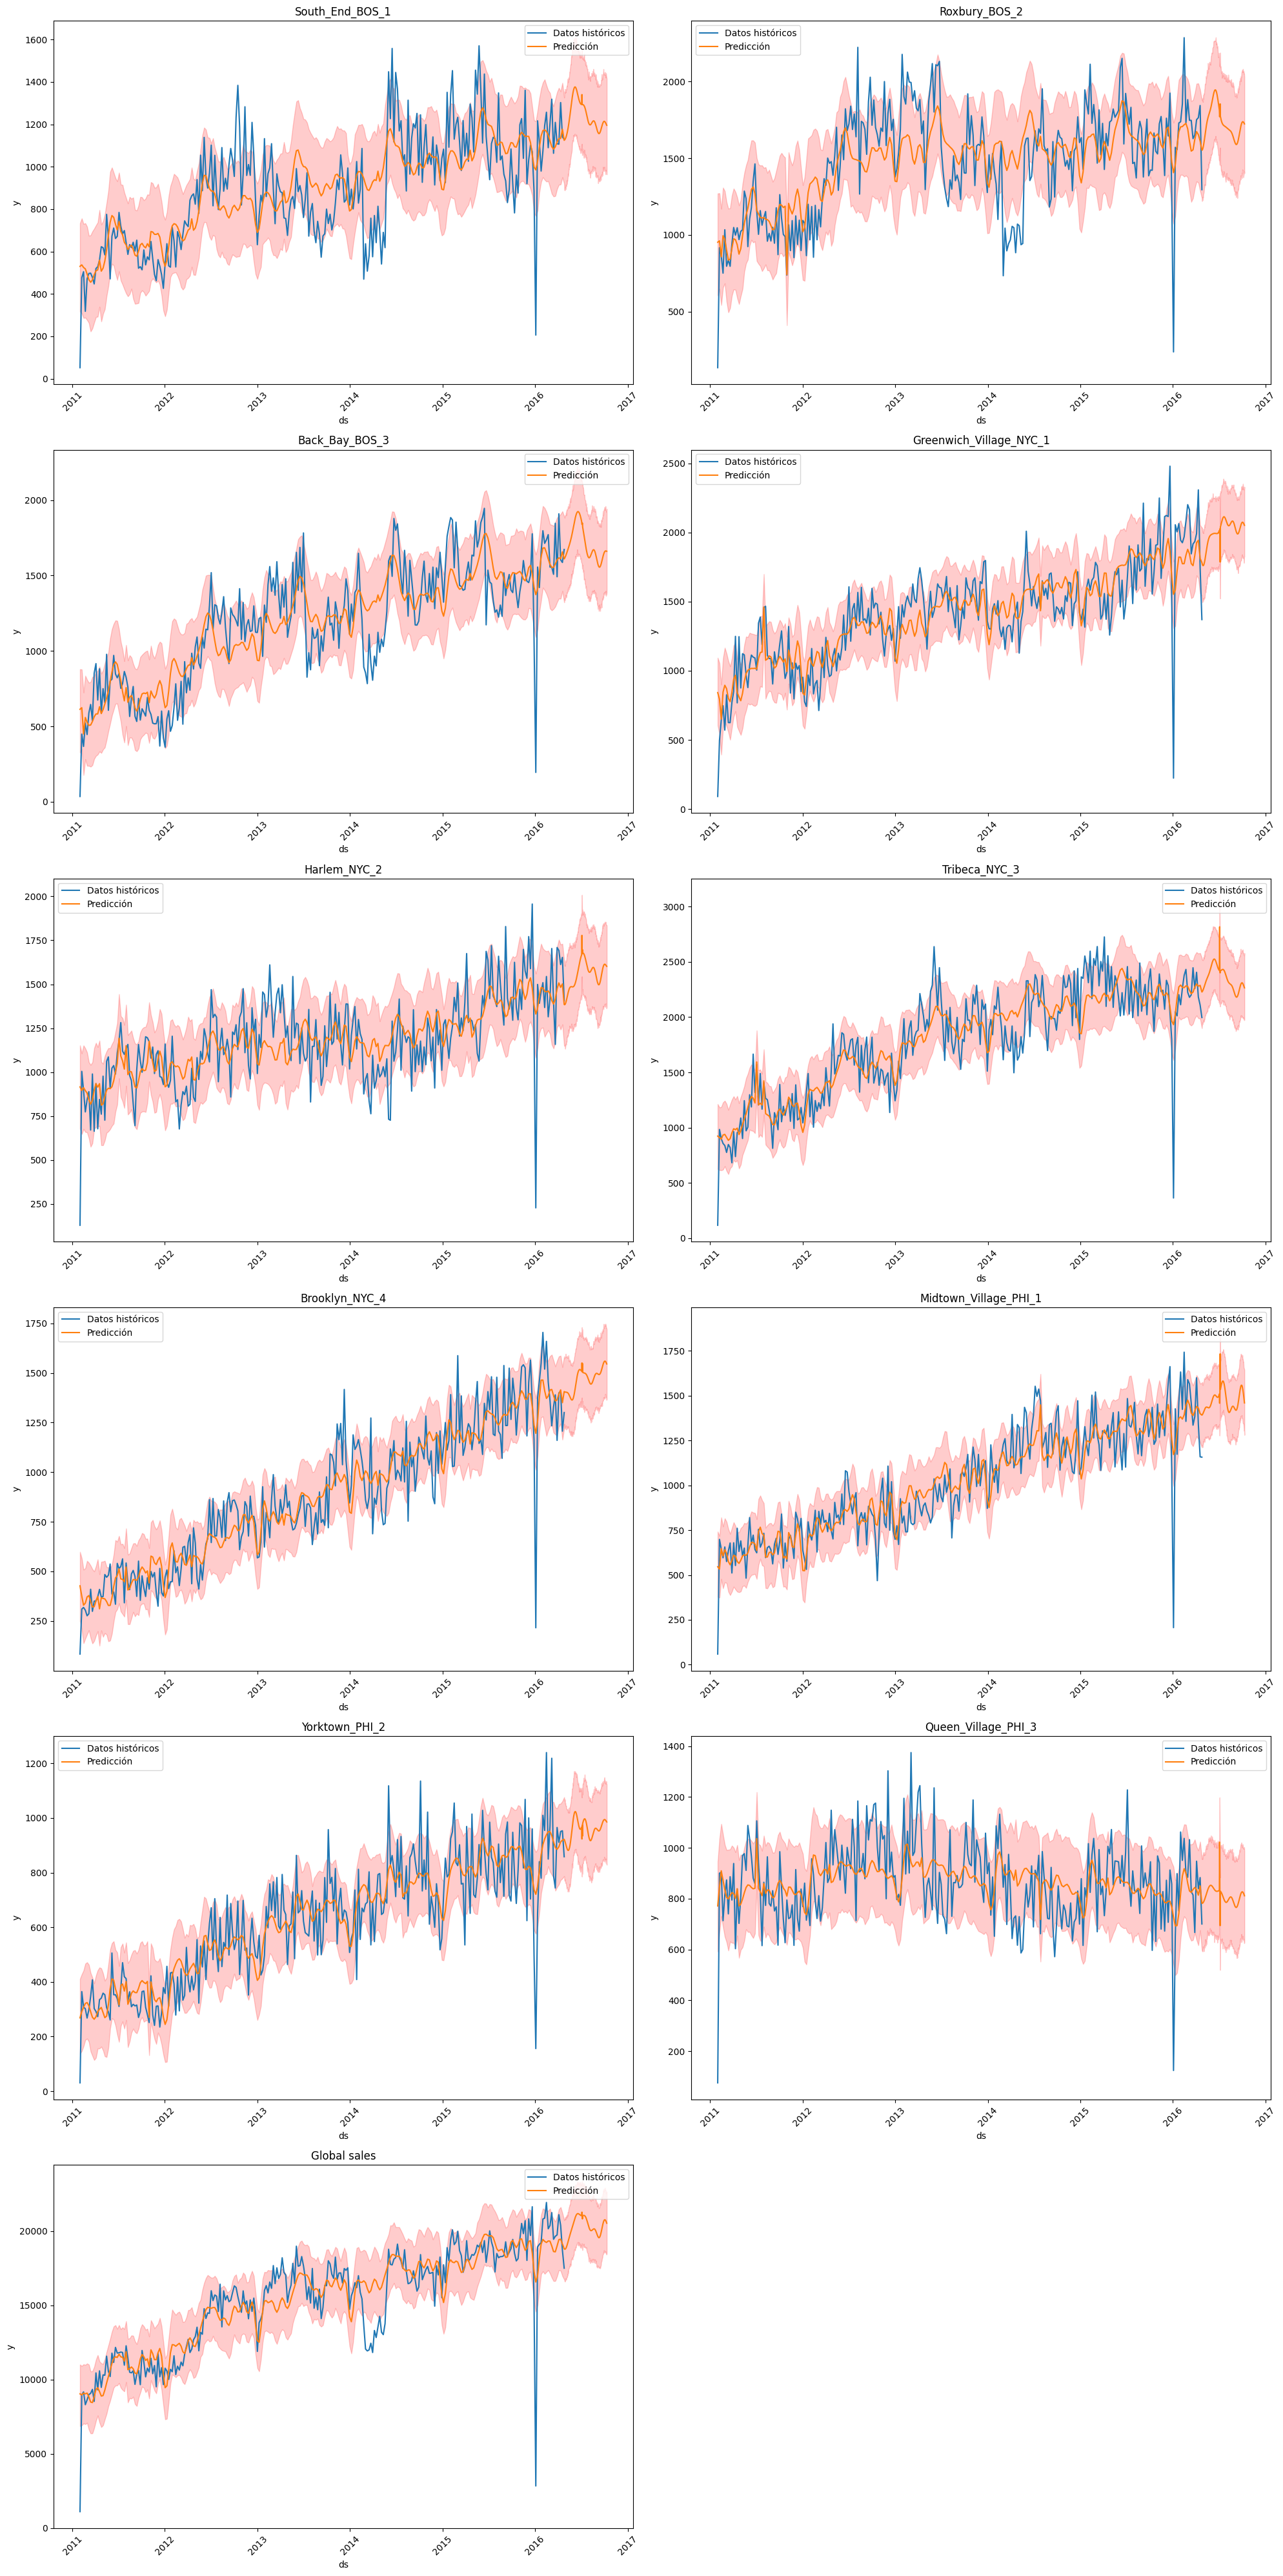

ds            store          yhat         trend    yhat_lower  \
0    2011-01-31  South_End_BOS_1    530.051725    513.607563    315.891796   
1    2011-02-07  South_End_BOS_1    536.979831    517.332089    308.954012   
2    2011-02-14  South_End_BOS_1    524.824001    521.056614    286.441963   
3    2011-02-21  South_End_BOS_1    518.087519    524.781140    288.201254   
4    2011-02-28  South_End_BOS_1    493.731198    528.505665    276.882620   
...         ...              ...           ...           ...           ...   
4857 2016-10-06     Global sales  20688.423074  20165.610473  18537.249737   
4858 2016-10-07     Global sales  20652.677085  20169.360197  18485.562724   
4859 2016-10-08     Global sales  20611.506957  20173.109922  18459.200754   
4860 2016-10-09     Global sales  20566.473603  20176.859646  18407.899432   
4861 2016-10-10     Global sales  20519.229567  20180.609371  18474.119142   

        yhat_upper         y  
0       733.329192   51.9897  
1       756.272681  476.5656  
2       730.037631  504.6286  
3       733.477448  317.8567  
4       717.294624  471.0461  
...            ...       ...  
4857  22725.010913       NaN  
4858  22516.128611       NaN  
4859  22659.411233       NaN  
4860  22657.690130       NaN  
4861  22611.588457       NaN  

[4862 rows x 7 columns]

In [28]:
prophet_store_prediction(dict_tienda,df_events, 24)

PROXIMOS PASOS


El Error Porcentual Absoluto Medio (MAPE, por sus siglas en inglés) es una métrica comúnmente utilizada para evaluar la precisión de las predicciones en problemas de series temporales. Se expresa como un porcentaje, lo que facilita su interpretación en términos de "error promedio" respecto a los valores reales. Un MAPE de 0.09 significa que, en promedio, las predicciones se desvían en un 9% de los valores reales.

Decidir si un MAPE del 9% es bueno depende de varios factores:

Contexto y aplicación: En algunas aplicaciones, un 9% de error puede ser excelente. Por ejemplo, en pronósticos económicos a largo plazo, un MAPE del 9% podría considerarse muy preciso. Sin embargo, en otras aplicaciones donde se requiere mayor precisión, como en la previsión de la demanda de inventario para productos de alta rotación, un 9% podría ser demasiado alto.

Comparación con un modelo de referencia: Es útil comparar el MAPE de tu modelo con el de un modelo de referencia simple, como un modelo de caminata aleatoria, el último valor conocido, o un promedio móvil. Si tu modelo no logra superar significativamente el rendimiento de un modelo de referencia simple, entonces un MAPE del 9% podría no ser tan impresionante.

Distribución de errores: Un MAPE bajo no siempre significa que el modelo es uniformemente bueno en todas las condiciones. Podría haber segmentos de tiempo donde el modelo tiene un rendimiento significativamente peor o mejor que el promedio. Es útil analizar la distribución de los errores para identificar patrones de cuándo y por qué ocurren los errores.

Comparación con estudios o benchmarks similares: Si hay estudios o benchmarks en tu área de aplicación específica, comparar tus resultados con estos puede proporcionar una perspectiva sobre qué tan bueno es un MAPE del 9%.

Tolerancia al error: Depende de cuánto error es aceptable en tu aplicación específica. Algunas decisiones o procesos pueden tolerar un cierto nivel de inexactitud sin consecuencias graves, mientras que en otros casos, incluso pequeños errores pueden tener implicaciones significativas.

En resumen, un MAPE del 9% puede ser considerado bueno en muchas situaciones, especialmente si los modelos predictivos anteriores o los métodos de referencia tenían errores más altos. Sin embargo, la evaluación debe hacerse considerando el contexto específico, la complejidad de los datos, y las expectativas de precisión para la aplicación en cuestión.




User
como podria mejorar esta metrica en mi modelo prophet
ChatGPT
Para mejorar el MAPE (Error Porcentual Absoluto Medio) de tus predicciones con Prophet, puedes considerar varias estrategias de ajuste y optimización. Aquí hay algunas sugerencias:

1. Ajuste de Hiperparámetros
Prophet permite ajustar varios hiperparámetros que pueden influir significativamente en la calidad de las predicciones:

changepoint_prior_scale: Aumentar este valor permite al modelo adaptarse más rápidamente a los cambios históricos, pero puede llevar a sobreajuste. Experimenta con valores más altos o más bajos.
seasonality_prior_scale: Similar al anterior, controla la flexibilidad de la sazonalidad. Ajustar este valor puede ayudar a capturar mejor las fluctuaciones estacionales.
holidays_prior_scale: Si estás usando festividades o eventos especiales, ajustar este parámetro puede mejorar cómo el modelo considera el impacto de estos eventos.
2. Adición de Festividades y Eventos Especiales
Si hay eventos específicos que sabes que afectan tus datos (como festividades o promociones), asegúrate de incluirlos en tu modelo mediante el parámetro holidays. Esto puede ayudar al modelo a anticipar cambios significativos en los datos.

3. Inclusión de Regresores Adicionales
Si hay variables externas que influencian tus series temporales, como variables económicas, clima, o indicadores de mercado, puedes incluirlas como regresores adicionales en Prophet mediante el método add_regressor(). Esto puede mejorar la precisión de las predicciones al considerar más factores que afectan la serie temporal.

4. Ajuste de la Sazonalidad
Prophet automáticamente ajusta la sazonalidad anual, semanal y diaria, pero puedes personalizarla:

Usa add_seasonality para añadir patrones de sazonalidad personalizados que puedan ser relevantes para tus datos.
Ajusta la sazonalidad para capturar ciclos no estándar que Prophet no detecta automáticamente.
5. Validación Cruzada y Ajuste Fino
Utiliza la validación cruzada proporcionada por Prophet para evaluar el rendimiento de tu modelo bajo diferentes configuraciones de hiperparámetros. Esto puede ayudarte a encontrar el mejor conjunto de hiperparámetros que minimiza el MAPE.

6. Transformaciones de Datos
En algunos casos, transformar tus datos antes de modelar puede ayudar:

Transformaciones logarítmicas pueden estabilizar la varianza y hacer que la serie sea más "modelable".
Diferenciación si tu serie temporal no es estacionaria.
7. Revisión y Limpieza de Datos
Asegúrate de que tus datos están limpios y libres de errores antes de modelar.
Revisa la presencia de valores atípicos que puedan afectar negativamente el rendimiento del modelo.
Implementar estas estrategias puede requerir iteración

### Tuneo hiperparametros y cross validation

Aqui vamos a utilizar validacion cruzada para aumentar la robusted de nuestro modelo. Adicionalmente afinaremos los hiperparametros del modelo para ver si puede mejorar las metricas.

Usaremos una biblioteca de scikit-learn(skopt) ya que prophet en sí no tiene un tuneo automatico como esta biblioteca si, y se nos haría muy tedioso hacerlo manualmente. Esta permite hacer una optimizacion de parametros de forma bayesiana.

Estamos utilizando el MAPE(Mean average percentage error) como metrica para cuantificar el error ya que se interpreta más facil. Esta metrica no podriamos usarla si tuvieramos valores 0 ya que los valores se disparan (por lo de ser un porcentaje).

In [2]:
# instalamos biblioteca skopt

# !pip install scikit-optimize

In [41]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
import pandas as pd
import numpy as np


# Supongamos que 'df' es tu DataFrame con las columnas 'ds' y 'y'
# en nuestro caso vamos a usar un cualquier tienda ya que los datos deberian comportarse similares
# usaremos df_prophet_BOS_1_South_end

# Define el espacio de búsqueda de hiperparámetros
space = [
    Integer(10, 30, name='n_changepoints'),  # Ajustando el número de puntos de cambio
    Real(0.001, 0.99, name='changepoint_prior_scale'),  # Rango más amplio para changepoint_prior_scale
    Real(0.01, 20.0, name='seasonality_prior_scale'),  # Rango más amplio para seasonality_prior_scale
    Categorical(['additive', 'multiplicative'], name='seasonality_mode'),  # Modo de sazonalidad
    Categorical(['auto'], name='yearly_seasonality'),  # Auto detectar sazonalidad anual
    Categorical(['auto'], name='weekly_seasonality'),  # Auto detectar sazonalidad semanal
    Categorical(['auto'], name='daily_seasonality'),  # Auto detectar sazonalidad diaria
    Real(0.8, 0.95, name='changepoint_range')]


# Define una función objetivo para la optimización
@use_named_args(space)
def objective(**params):
    m = Prophet(**params)
    m.fit(df_prophet_BOS_1_South_End)
    df_cv = cross_validation(m, initial='365 days', period='180 days', horizon= '168 days')
    df_p = performance_metrics(df_cv)
    # Utilizaremos el MAPE como métrica de rendimiento
    mape = df_p['mape'].mean()
    return mape



In [42]:

# Ejecuta la optimización bayesiana
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:\n")
best_params = {dim.name: res_gp.x[i] for i, dim in enumerate(space)}
for param, value in best_params.items():
    print(f"{param}: {value}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/orwqa8_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/rc5b543s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18955', 'data', 'file=/tmp/tmpx__sqktv/orwqa8_i.json', 'init=/tmp/tmpx__sqktv/rc5b543s.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model46pzsudm/prophet_model-20240410154124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/llz0h07a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/0pha4n4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99401', 'data', 'file=/tmp/tmpx__sqktv/llz0h07a.json', 'init=/tmp/tmpx__sqktv/0pha4n4s.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelh152w_su/prophet_model-20240410154124.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/ax6k7ope.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/teiah581.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/g24q5spo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/fh_jq_vz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53296', 'data', 'file=/tmp/tmpx__sqktv/g24q5spo.json', 'init=/tmp/tmpx__sqktv/fh_jq_vz.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model9kp0urxc/prophet_model-20240410154129.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/7vm88jds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/4sns3ljp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/tcskln7o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/u1suk4zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84965', 'data', 'file=/tmp/tmpx__sqktv/tcskln7o.json', 'init=/tmp/tmpx__sqktv/u1suk4zo.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model34yskko0/prophet_model-20240410154132.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/shzrzkyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/qbtm157b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/xqbre_8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/rqqdu3by.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65630', 'data', 'file=/tmp/tmpx__sqktv/xqbre_8r.json', 'init=/tmp/tmpx__sqktv/rqqdu3by.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelrq7mrj2c/prophet_model-20240410154134.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/70onmb45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/bnm2wl8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/nym9tgt5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/124o0tud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60164', 'data', 'file=/tmp/tmpx__sqktv/nym9tgt5.json', 'init=/tmp/tmpx__sqktv/124o0tud.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model_4cqtfpi/prophet_model-20240410154138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/558fp_vn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/pgjqb0uu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/nm3ua2d8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/dtzntaf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56364', 'data', 'file=/tmp/tmpx__sqktv/nm3ua2d8.json', 'init=/tmp/tmpx__sqktv/dtzntaf6.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelxi_h18j0/prophet_model-20240410154143.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/4mfhsnjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/igfgg1yv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/8s9wa3n7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/ko8u3i3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98636', 'data', 'file=/tmp/tmpx__sqktv/8s9wa3n7.json', 'init=/tmp/tmpx__sqktv/ko8u3i3f.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelbob0vn95/prophet_model-20240410154149.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/f9lwqlqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/nd8_c4g_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/52snu75y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/n2n0eqp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34803', 'data', 'file=/tmp/tmpx__sqktv/52snu75y.json', 'init=/tmp/tmpx__sqktv/n2n0eqp8.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model5jxy1zdj/prophet_model-20240410154152.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/0dvwgwja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/h9ikizrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/p275c551.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/wb1luaw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42153', 'data', 'file=/tmp/tmpx__sqktv/p275c551.json', 'init=/tmp/tmpx__sqktv/wb1luaw2.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelgo0yk49j/prophet_model-20240410154156.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/2k2ug4h8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/xfgg7gcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/s165o898.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/ie0k21bv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74295', 'data', 'file=/tmp/tmpx__sqktv/s165o898.json', 'init=/tmp/tmpx__sqktv/ie0k21bv.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model7o0agj91/prophet_model-20240410154159.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/a3d5ceqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/p8w26lyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/x4cm8324.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/ketypjzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6809', 'data', 'file=/tmp/tmpx__sqktv/x4cm8324.json', 'init=/tmp/tmpx__sqktv/ketypjzt.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model23v3wqry/prophet_model-20240410154203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/60jdflym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/js0gr9qr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/pv0pr0jd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/t2a0jz8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46116', 'data', 'file=/tmp/tmpx__sqktv/pv0pr0jd.json', 'init=/tmp/tmpx__sqktv/t2a0jz8a.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model4x_sziwj/prophet_model-20240410154209.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/e8jldl5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/ss7frxqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/hc_9j9zr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/p2hrxjlo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86959', 'data', 'file=/tmp/tmpx__sqktv/hc_9j9zr.json', 'init=/tmp/tmpx__sqktv/p2hrxjlo.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelfwdfj6j1/prophet_model-20240410154212.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/e0k9d6tg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/jhi5orp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/whpkzpkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/fqc460lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23257', 'data', 'file=/tmp/tmpx__sqktv/whpkzpkj.json', 'init=/tmp/tmpx__sqktv/fqc460lr.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modeltdj63upr/prophet_model-20240410154215.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/8mzmda02.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/u4gds9xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/irscxq8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/lgwqs7fe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14444', 'data', 'file=/tmp/tmpx__sqktv/irscxq8f.json', 'init=/tmp/tmpx__sqktv/lgwqs7fe.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelknw0myk9/prophet_model-20240410154221.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/yt2ggzl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/mt7dqyur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/g2e5el5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/ovcjfbql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68880', 'data', 'file=/tmp/tmpx__sqktv/g2e5el5d.json', 'init=/tmp/tmpx__sqktv/ovcjfbql.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelcb11yp9h/prophet_model-20240410154229.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/q760yqj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/fu0tnxb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/sln9m577.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/hdlp1nnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22540', 'data', 'file=/tmp/tmpx__sqktv/sln9m577.json', 'init=/tmp/tmpx__sqktv/hdlp1nnt.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelenudf4t6/prophet_model-20240410154232.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/6oz3p3xd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/1ags_lf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/7k28av6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/z6avtq8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44974', 'data', 'file=/tmp/tmpx__sqktv/7k28av6u.json', 'init=/tmp/tmpx__sqktv/z6avtq8f.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelm0ocikjb/prophet_model-20240410154235.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/rinveor_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/bi2oogxj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/is2t93y2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/mkt7js5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8288', 'data', 'file=/tmp/tmpx__sqktv/is2t93y2.json', 'init=/tmp/tmpx__sqktv/mkt7js5w.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model5m2nkhiq/prophet_model-20240410154239.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/w2t03pv1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/rg89ay0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/poeoiwmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/fqie9n3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74193', 'data', 'file=/tmp/tmpx__sqktv/poeoiwmr.json', 'init=/tmp/tmpx__sqktv/fqie9n3x.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modeldhn65dza/prophet_model-20240410154244.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/hq3hlfff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/cgswar_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Mejores hiperparámetros encontrados:

n_changepoints: 11
changepoint_prior_scale: 0.99
seasonality_prior_scale: 13.75131011140642
seasonality_mode: additive
yearly_seasonality: auto
weekly_seasonality: auto
daily_seasonality: auto
changepoint_range: 0.8814622158973394


In [40]:
best_params

{'n_changepoints': 11,
 'changepoint_prior_scale': 0.017020976691179888,
 'seasonality_prior_scale': 2.497294636668426,
 'seasonality_mode': 'multiplicative',
 'yearly_seasonality': 'auto',
 'weekly_seasonality': 'auto',
 'daily_seasonality': 'auto',
 'changepoint_range': 0.8706302706327486}

In [43]:
# aqui haciendose la CV de año a año
best_params

{'n_changepoints': 11,
 'changepoint_prior_scale': 0.99,
 'seasonality_prior_scale': 13.75131011140642,
 'seasonality_mode': 'additive',
 'yearly_seasonality': 'auto',
 'weekly_seasonality': 'auto',
 'daily_seasonality': 'auto',
 'changepoint_range': 0.8814622158973394}

In [46]:
def prophet_store_prediction(dict_tienda, df_events, periods_weeks, best_params):
    # Configurar el tamaño de la figura para los subplots
    plt.figure(figsize=(20, 40))

    # Inicializamos una lista vacía para almacenar los resultados de todas las tiendas
    todas_predicciones = []

    for idx, (nombre_tienda, df_tienda) in enumerate(dict_tienda.items()):
        # Extraemos los hiperparámetros para esta tienda
        params = best_params.get(nombre_tienda, {})

        # Creamos y ajustamos el modelo Prophet con los hiperparámetros seleccionados
        model = Prophet(holidays=df_events, **params)
        model.fit(df_tienda)

        # Realizamos la validación cruzada
        df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='168 days')
        df_p = performance_metrics(df_cv)
        mape = df_p['mape'].mean()
        print(f'MAPE para {nombre_tienda}: {mape}')

        # Predecimos el futuro
        future = model.make_future_dataframe(periods=periods_weeks, freq='W')
        forecast = model.predict(future)

        # Seleccionamos el subplot adecuado
        ax = plt.subplot(6, 2, idx + 1)

        # Visualizamos los datos históricos y las predicciones
        sns.lineplot(data=df_tienda, x='ds', y='y', label='Datos históricos', ax=ax)
        sns.lineplot(data=forecast, x='ds', y='yhat', label='Predicción', ax=ax)

        # Añadimos los intervalos de confianza
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Intervalo de confianza')

        # Agregar las predicciones a la lista
        forecast['store'] = nombre_tienda
        forecast = forecast[['ds', 'store', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]
        forecast['y'] = df_tienda.set_index('ds').reindex(forecast.set_index('ds').index)['y'].reset_index(drop=True)
        todas_predicciones.append(forecast)


        # Limitamos el cálculo del MAPE y R2 solo a las fechas históricas
        forecasted = forecast[['ds', 'yhat']].merge(df_tienda, on='ds', how='right')
        y_true = df_tienda['y']
        y_pred = forecasted['yhat']


        # Calculamos el MAPE y R2
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Título del subplot
        plt.title(f'{nombre_tienda} - MAPE: {mape:.2f}%, R2: {r2:.2f}')
        # Rotar las etiquetas del eje X para mejor lectura

        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Concatenar todas las predicciones en un único DataFrame
    df_predicciones_prophet = pd.concat(todas_predicciones, ignore_index=True)

    return df_predicciones_prophet


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/n3h2up8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/glteeux1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59568', 'data', 'file=/tmp/tmpx__sqktv/n3h2up8r.json', 'init=/tmp/tmpx__sqktv/glteeux1.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelqrhlugxt/prophet_model-20240410155429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/pqqm_q5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/kooqk3wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35202', 'data', 'file=/tmp/tmpx__sqktv/pqqm_q5r.json', 'init=/tmp/tmpx__sqktv/kooqk3wl.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelx_79uven/prophet_model-20240410155429.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/pj7bl7to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/knvtc2_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para South_End_BOS_1: 0.12820111207613172


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/hm5t0j4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/woovnxq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94830', 'data', 'file=/tmp/tmpx__sqktv/hm5t0j4b.json', 'init=/tmp/tmpx__sqktv/woovnxq5.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modeluo9v3x7d/prophet_model-20240410155433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/5tnvd39i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/z0zfksuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27009', 'data', 'file=/tmp/tmpx__sqktv/5tnvd39i.json', 'init=/tmp/tmpx__sqktv/z0zfksuw.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model7130u60w/prophet_model-20240410155433.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:54:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/_clkfdjv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/xqd_ifp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Roxbury_BOS_2: 0.1642191183654933


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/4l0halsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/cl8s3sjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27543', 'data', 'file=/tmp/tmpx__sqktv/4l0halsd.json', 'init=/tmp/tmpx__sqktv/cl8s3sjs.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelqv54hxo2/prophet_model-20240410155439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/5oi8c_lz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/1kpxmxyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14300', 'data', 'file=/tmp/tmpx__sqktv/5oi8c_lz.json', 'init=/tmp/tmpx__sqktv/1kpxmxyn.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelahw_i5a5/prophet_model-20240410155439.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:54:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/emzqcppg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/69trsp1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Back_Bay_BOS_3: 0.16883344080240276


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/twfstao1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/z6j7ssv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41759', 'data', 'file=/tmp/tmpx__sqktv/twfstao1.json', 'init=/tmp/tmpx__sqktv/z6j7ssv9.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelz3g26tlh/prophet_model-20240410155444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/dz6_6hjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/knfwoi1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40879', 'data', 'file=/tmp/tmpx__sqktv/dz6_6hjx.json', 'init=/tmp/tmpx__sqktv/knfwoi1b.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modellerkidps/prophet_model-20240410155444.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:54:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/2drg2_lg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/75sg4xrz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Greenwich_Village_NYC_1: 0.1158256329034268


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/h0pt5awu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/jk6ucikn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44406', 'data', 'file=/tmp/tmpx__sqktv/h0pt5awu.json', 'init=/tmp/tmpx__sqktv/jk6ucikn.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelfv4dkpni/prophet_model-20240410155448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/c_dw6z3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/2oq5jjnh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56066', 'data', 'file=/tmp/tmpx__sqktv/c_dw6z3z.json', 'init=/tmp/tmpx__sqktv/2oq5jjnh.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelbo4jiaxf/prophet_model-20240410155448.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:54:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/surv3yuv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/lib870ii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Harlem_NYC_2: 0.1573211054466432


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/3lr4y8z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/bdui3xre.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19324', 'data', 'file=/tmp/tmpx__sqktv/3lr4y8z5.json', 'init=/tmp/tmpx__sqktv/bdui3xre.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelmeuoz2cz/prophet_model-20240410155452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/da0aft3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/0189p12k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86992', 'data', 'file=/tmp/tmpx__sqktv/da0aft3b.json', 'init=/tmp/tmpx__sqktv/0189p12k.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelumsloa48/prophet_model-20240410155452.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:54:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/txbfcpwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/9d4t8sx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Tribeca_NYC_3: 0.11610941121505923


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/o8hfsryv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/wif5ubyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28654', 'data', 'file=/tmp/tmpx__sqktv/o8hfsryv.json', 'init=/tmp/tmpx__sqktv/wif5ubyc.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modellx8p46lj/prophet_model-20240410155457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/65pt1qvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/fko70ec7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35425', 'data', 'file=/tmp/tmpx__sqktv/65pt1qvi.json', 'init=/tmp/tmpx__sqktv/fko70ec7.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_models5sm16wb/prophet_model-20240410155457.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/ymbvc4yi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/g2v9anhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Brooklyn_NYC_4: 0.08773482292956378


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/bnosv6er.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/t12z8qj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88652', 'data', 'file=/tmp/tmpx__sqktv/bnosv6er.json', 'init=/tmp/tmpx__sqktv/t12z8qj4.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelylfnow6w/prophet_model-20240410155504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/zxzz4ooi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/fd4zzgsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18580', 'data', 'file=/tmp/tmpx__sqktv/zxzz4ooi.json', 'init=/tmp/tmpx__sqktv/fd4zzgsl.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_model301rwcrb/prophet_model-20240410155504.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:55:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/6djknc0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/qmq5k0hh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Midtown_Village_PHI_1: 0.11254916531358539


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/3ahqs5eu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/t4b81tmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55494', 'data', 'file=/tmp/tmpx__sqktv/3ahqs5eu.json', 'init=/tmp/tmpx__sqktv/t4b81tmf.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelps6v4wdv/prophet_model-20240410155507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/mixxryt5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/e_9_o0gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94254', 'data', 'file=/tmp/tmpx__sqktv/mixxryt5.json', 'init=/tmp/tmpx__sqktv/e_9_o0gz.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelagv1s0us/prophet_model-20240410155507.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:55:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/95dvjdr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/yj4nivqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Yorktown_PHI_2: 0.1941037257565212


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/1gropl74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/rbraxw06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63687', 'data', 'file=/tmp/tmpx__sqktv/1gropl74.json', 'init=/tmp/tmpx__sqktv/rbraxw06.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelf6nwvcc4/prophet_model-20240410155511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/y4h3925j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/h1aokbdk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12324', 'data', 'file=/tmp/tmpx__sqktv/y4h3925j.json', 'init=/tmp/tmpx__sqktv/h1aokbdk.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelq0iu2fr8/prophet_model-20240410155511.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:55:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/tf6se6sa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/4bc4mnth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Queen_Village_PHI_3: 0.17107351511902677


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/b34o2rz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/9pnw8bm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37940', 'data', 'file=/tmp/tmpx__sqktv/b34o2rz6.json', 'init=/tmp/tmpx__sqktv/9pnw8bm_.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelxnypypnf/prophet_model-20240410155515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/n4g_4an8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/1v5kwcnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27721', 'data', 'file=/tmp/tmpx__sqktv/n4g_4an8.json', 'init=/tmp/tmpx__sqktv/1v5kwcnk.json', 'output', 'file=/tmp/tmpx__sqktv/prophet_modelb_67zr0h/prophet_model-20240410155515.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:55:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/siucm9ui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx__sqktv/_vxyviz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Global sales: 0.10991016674901131


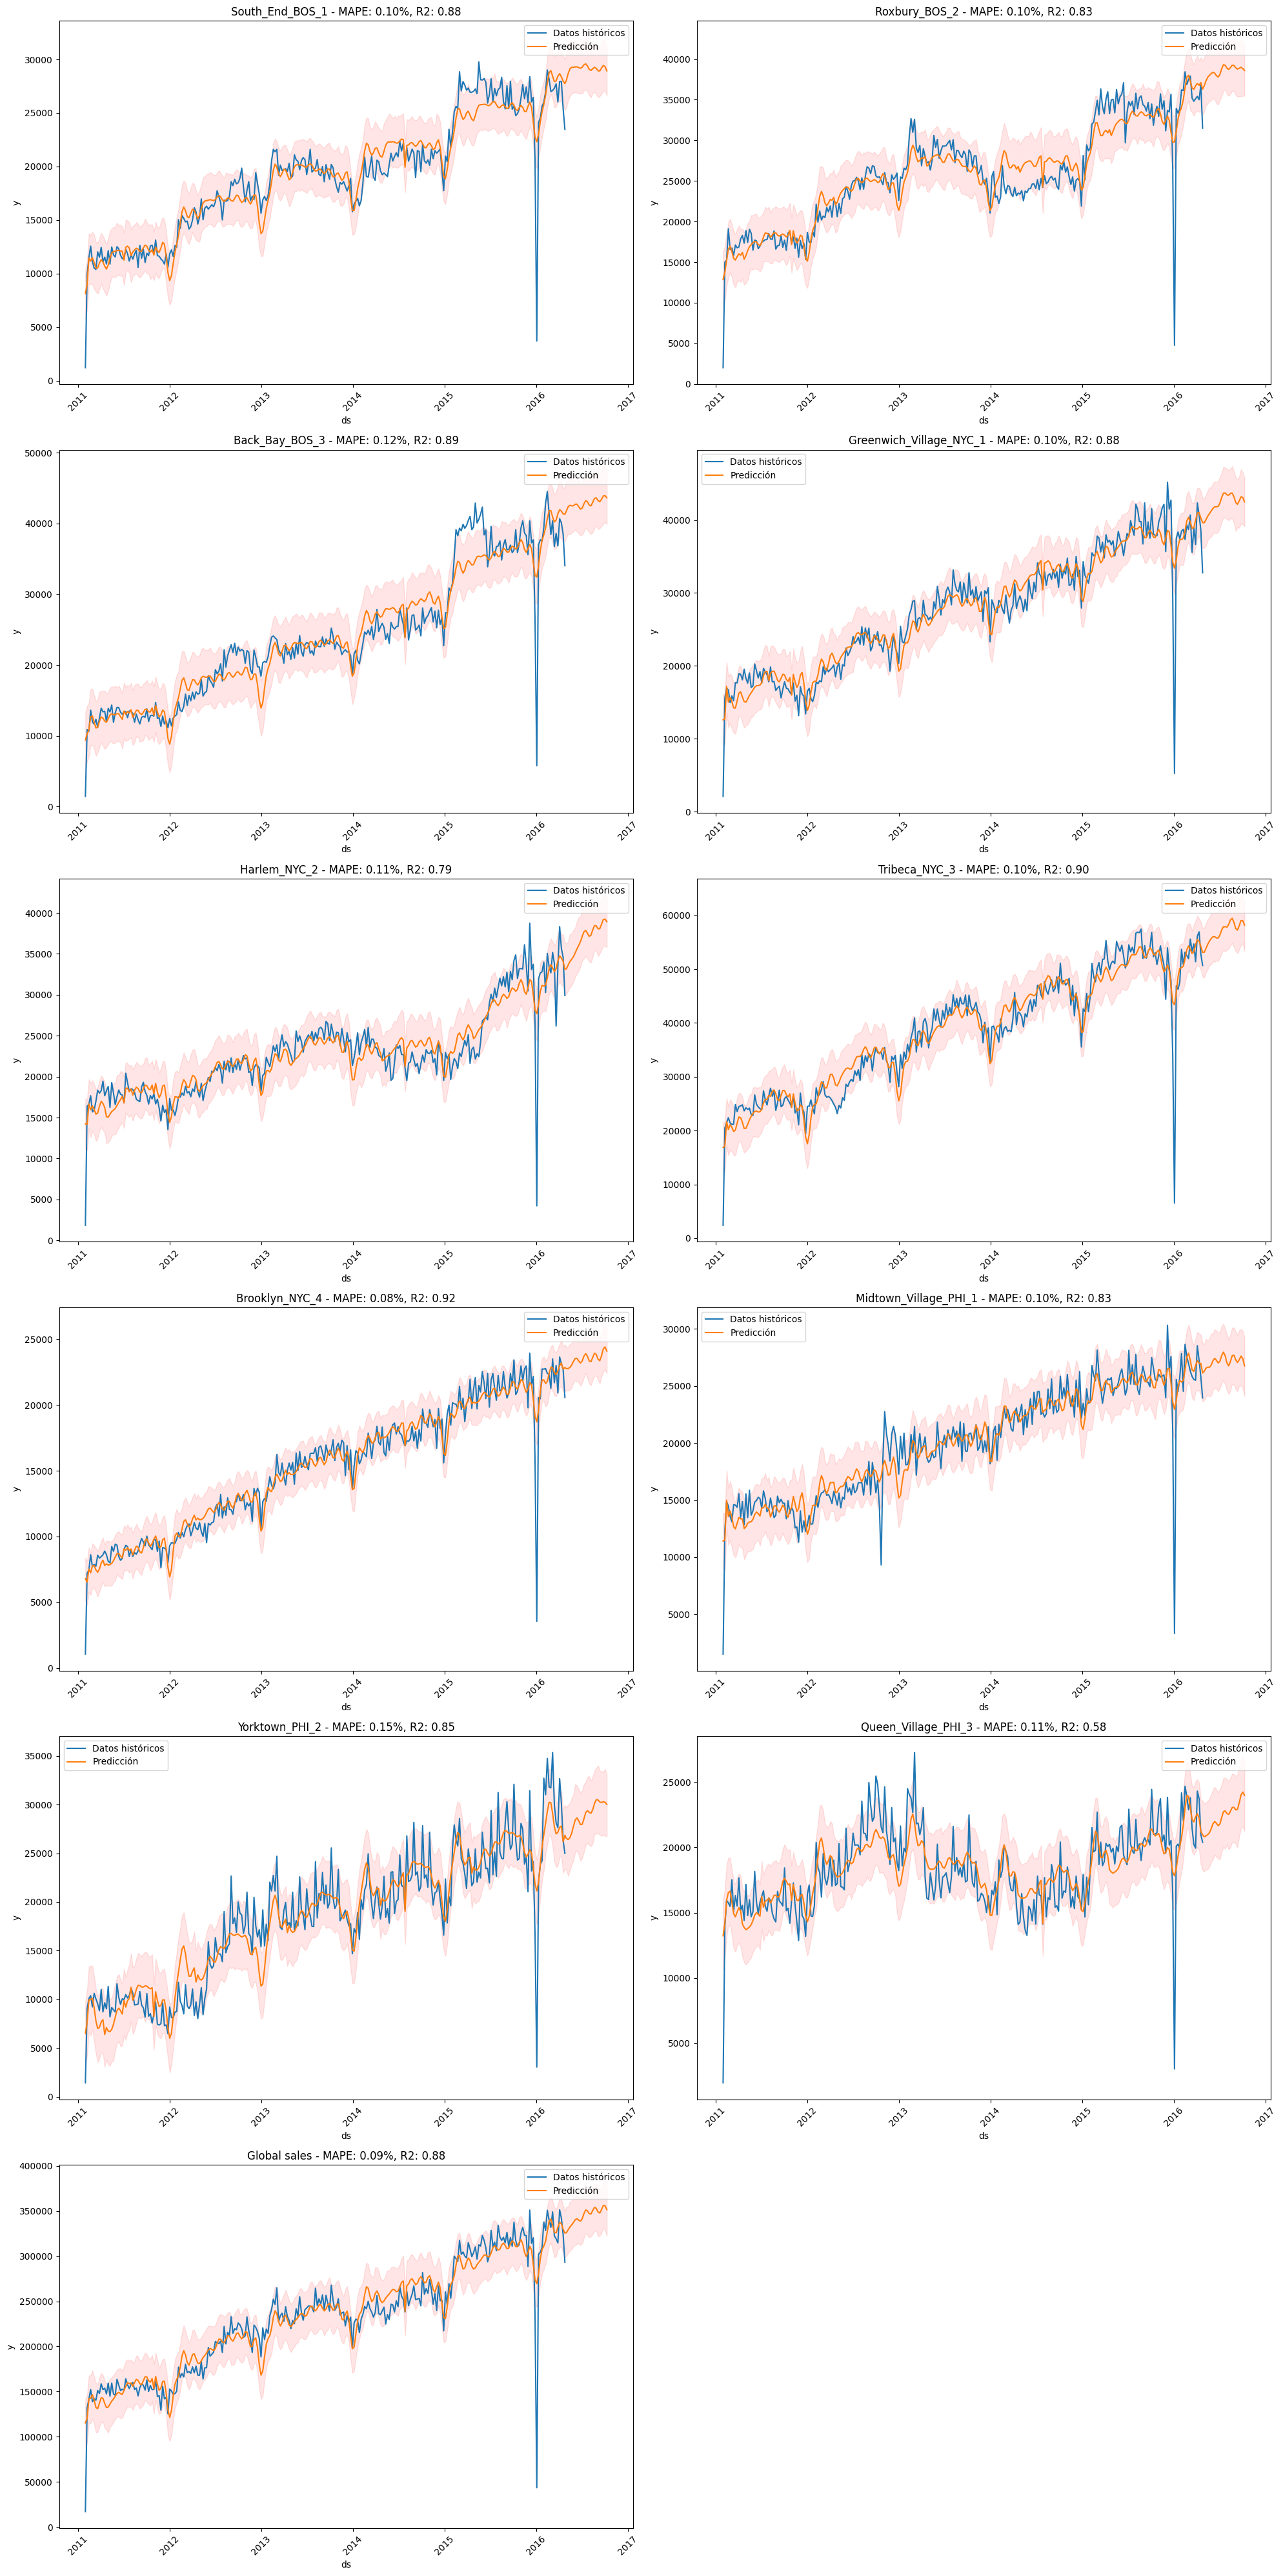

In [47]:
df_cv_hpt_prediccions= prophet_store_prediction(dict_tienda,df_events,24,best_params)

Bueno pues parece que no cambia mucho con la CV y el tuneo de hiperparametros

In [ ]:
df_pred_BOS_1

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2011-01-31  45968.763357  32157.424203  49116.922424  45968.763357   
1   2011-02-07  46235.574536  34993.082550  50948.701183  46235.574536   
2   2011-02-14  46502.385715  38031.152052  54604.417514  46502.385715   
3   2011-02-21  46769.196894  46835.314291  63568.499429  46769.196894   
4   2011-02-28  47036.008073  42901.414841  58504.026568  47036.008073   
..         ...           ...           ...           ...           ...   
277 2016-05-22  85888.220258  81752.122944  98265.189015  85880.757359   
278 2016-05-29  85991.848396  82852.210984  99221.478195  85979.110562   
279 2016-06-05  86095.476534  83693.095268  99680.058346  86075.620738   
280 2016-06-12  86199.104672  82624.182170  97738.271142  86174.626075   
281 2016-06-19  86302.732811  81199.403897  96692.092520  86270.100028   

      trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0    45968.763357            0.0                  0.0                  0.0   
1    46235.574536            0.0                  0.0                  0.0   
2    46502.385715            0.0                  0.0                  0.0   
3    46769.196894            0.0                  0.0                  0.0   
4    47036.008073            0.0                  0.0                  0.0   
..            ...            ...                  ...                  ...   
277  85891.800712            0.0                  0.0                  0.0   
278  85999.975183            0.0                  0.0                  0.0   
279  86109.166025            0.0                  0.0                  0.0   
280  86218.686743            0.0                  0.0                  0.0   
281  86328.113827            0.0                  0.0                  0.0   

     Christmas Day (observed)  ...     holidays  holidays_lower  \
0                         0.0  ...     0.000000        0.000000   
1                         0.0  ...     0.000000        0.000000   
2                         0.0  ...     0.000000        0.000000   
3                         0.0  ...  5909.769067     5909.769067   
4                         0.0  ...     0.000000        0.000000   
..                        ...  ...          ...             ...   
277                       0.0  ...     0.000000        0.000000   
278                       0.0  ...     0.000000        0.000000   
279                       0.0  ...     0.000000        0.000000   
280                       0.0  ...     0.000000        0.000000   
281                       0.0  ...     0.000000        0.000000   

     holidays_upper       yearly  yearly_lower  yearly_upper  \
0          0.000000 -5133.449628  -5133.449628  -5133.449628   
1          0.000000 -3207.046891  -3207.046891  -3207.046891   
2          0.000000  -488.979289   -488.979289   -488.979289   
3       5909.769067  2244.646823   2244.646823   2244.646823   
4          0.000000  3716.011306   3716.011306   3716.011306   
..              ...          ...           ...           ...   
277        0.000000  4194.385660   4194.385660   4194.385660   
278        0.000000  5360.469203   5360.469203   5360.469203   
279        0.000000  5283.784622   5283.784622   5283.784622   
280        0.000000  4055.157548   4055.157548   4055.157548   
281        0.000000  2692.531574   2692.531574   2692.531574   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
277                   0.0                         0.0   
278                   0.0                         0.0   
279                   0.0                         0.0   
280                   0.0                 

<Axes: xlabel='ds', ylabel='y'>

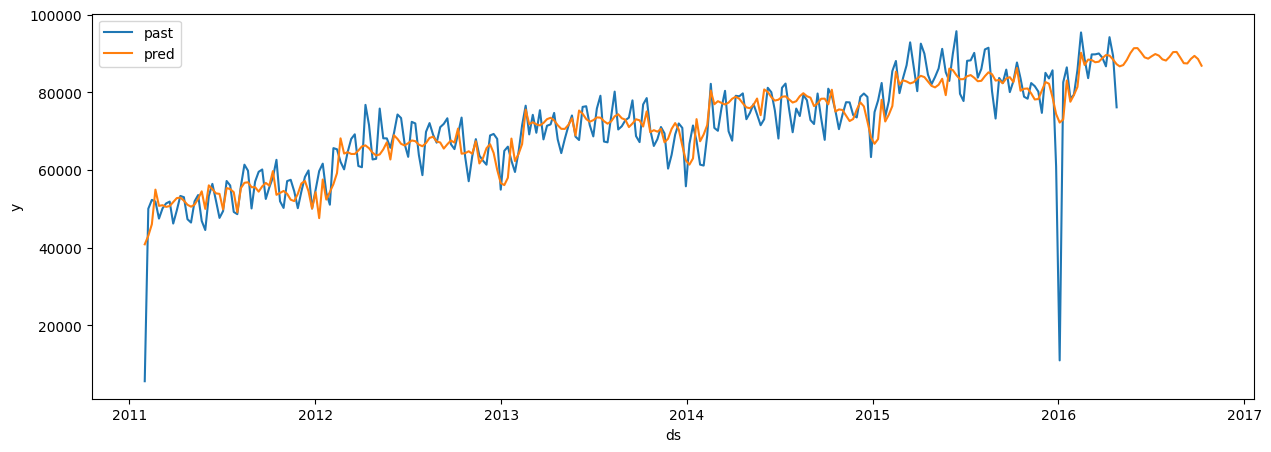

In [ ]:
# representamos la prediccion respecto a los datos reales


plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_BOS_1,x='ds',y='y',label='past')

sns.lineplot(data=df_pred_BOS_1,x='ds',y='yhat',label='pred')

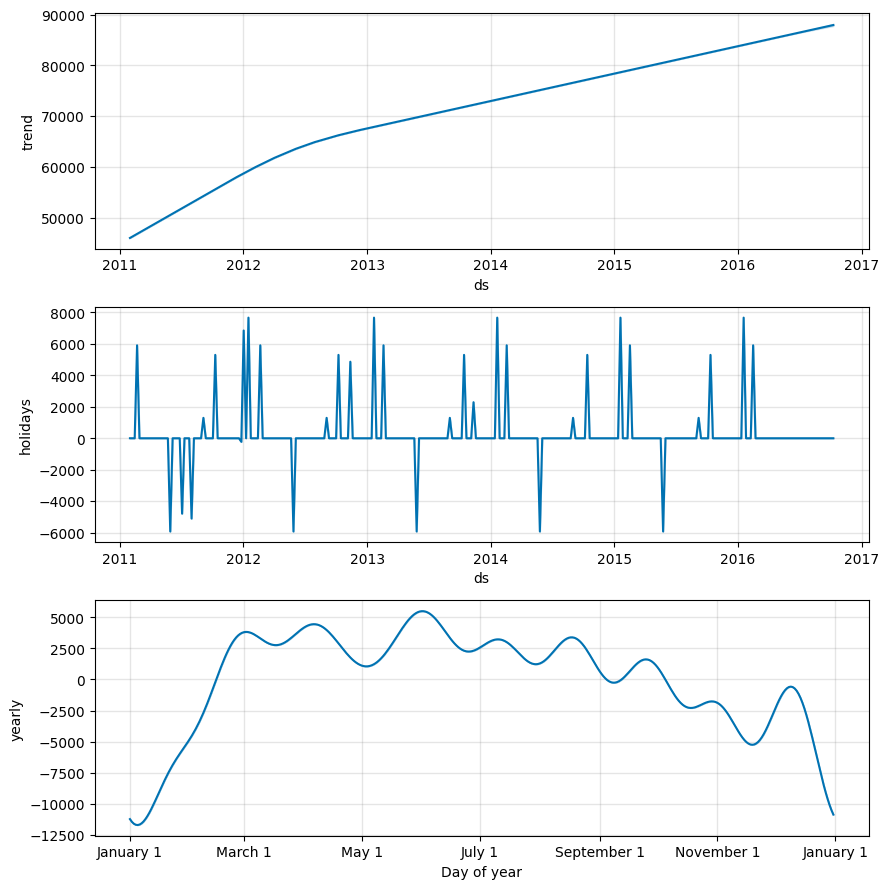

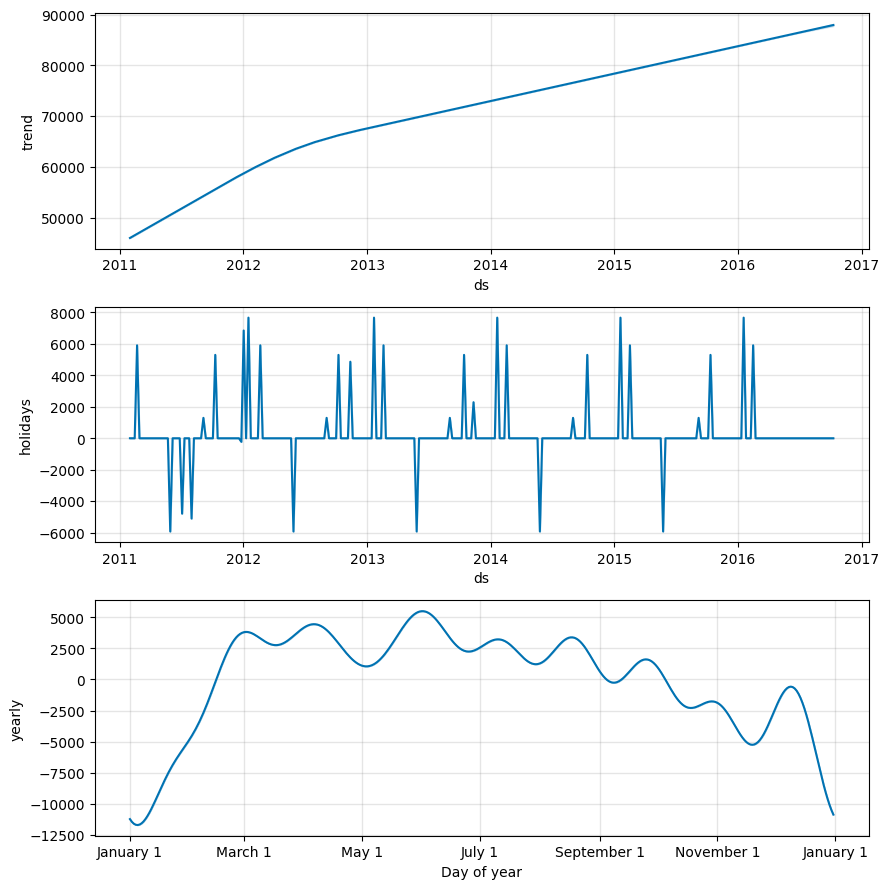

In [ ]:
model.plot_components(df_pred_BOS_1)

In [ ]:
# y hacemos la prediccion

df_pred_boston = model.make_future_dataframe(periods=len(df_South_End_BOS_1_test),freq='W')

<Axes: xlabel='date', ylabel='total_sales'>

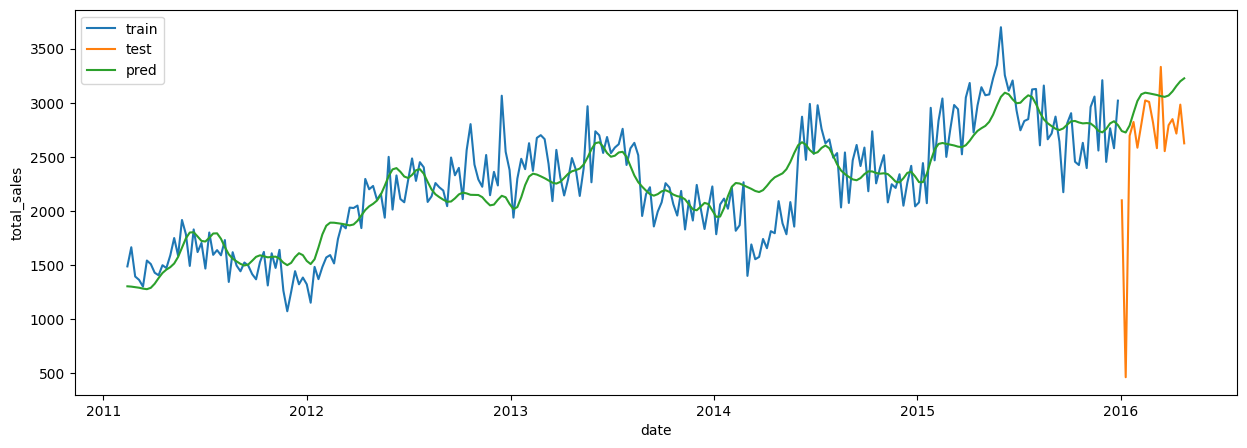

In [ ]:
# representamos la prediccion respecto a los datos reales

df_pred_boston = model.predict(df_pred_boston)

plt.figure(figsize=(15, 5))

sns.lineplot(data=df_South_End_BOS_1_train.reset_index(),x='date',y='total_sales',label='train')
sns.lineplot(data=df_South_End_BOS_1_test.reset_index(),x='date',y='total_sales',label='test')
sns.lineplot(data=df_pred_boston,x='ds',y='yhat',label='pred')

In [ ]:
# ahora haremos una prediccion para todo el 2016 y mitad del 2017

df_pred_boston_2 = model.make_future_dataframe(periods=80,freq='W')

<Axes: xlabel='date', ylabel='total_sales'>

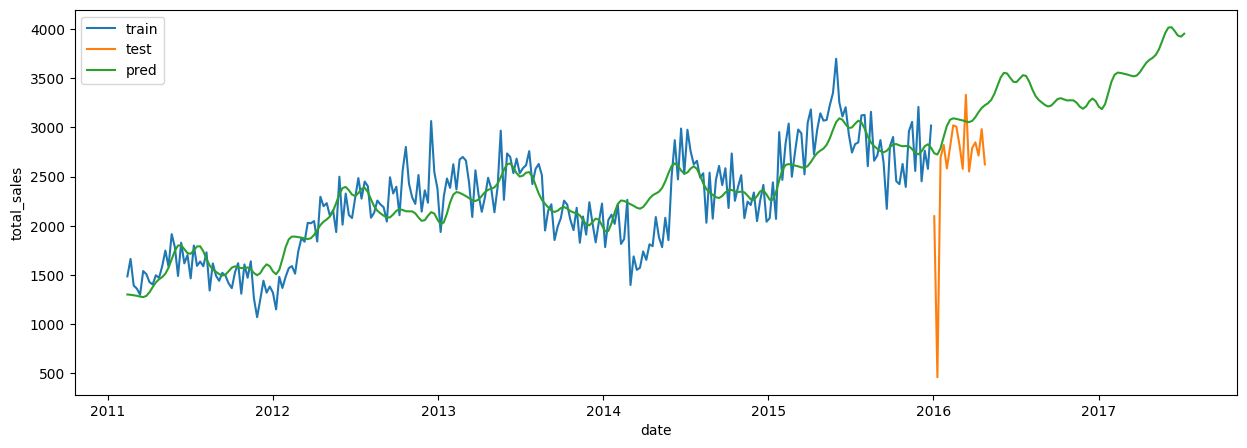

In [ ]:
df_pred_boston_2 = model.predict(df_pred_boston_2)

plt.figure(figsize=(15, 5))

sns.lineplot(data=df_South_End_BOS_1_train.reset_index(),x='date',y='total_sales',label='train')
sns.lineplot(data=df_South_End_BOS_1_test.reset_index(),x='date',y='total_sales',label='test')
sns.lineplot(data=df_pred_boston_2,x='ds',y='yhat',label='pred')